In [3]:
ls

LICENSE                    Untitled5.ipynb      src/
Minimal_example.ipynb      docs/                tests/
Parquet_testing.ipynb      error.ipynb          tiny_lsst.ipynb
README.md                  jit_fun.cloudpickle  tiny_lsst2.ipynb
Tensorflow_tutorial.ipynb  pyproject.toml       ztf_reader.ipynb


In [1]:
import sys
print(sys.path)

['/astro/users/ncaplar/epyc_notebooks', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python310.zip', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/lib-dynload', '', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/astro/users/ncaplar/github/tinygp_carma/tinygp/src']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm

import jax
import jax.numpy as jnp
import jaxopt
# makes sure you are running on 64 precision 
jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import kernels, GaussianProcess
from tinygp.kernels import quasisep
print(tinygp.__version__)

import lsstseries as ls
from lsstseries import Ensemble

# print out all outputs from the cell, not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


0.2.3.dev57+g60dde94


In [3]:
# we overload ls - not sure this is the best thing to be doing
ls

<module 'lsstseries' from '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/lsstseries/__init__.py'>

# Test case - SHOW

In [4]:
# Define a context manager to suppress stdout and stderr.
# Helps with suppresing superflous output
import os
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in 
    Python, i.e. will suppress all print, even if the print originates in a 
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).      

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds =  [os.open(os.devnull,os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0],1)
        os.dup2(self.null_fds[1],2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0],1)
        os.dup2(self.save_fds[1],2)
        # Close all file descriptors
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

number of points: 125


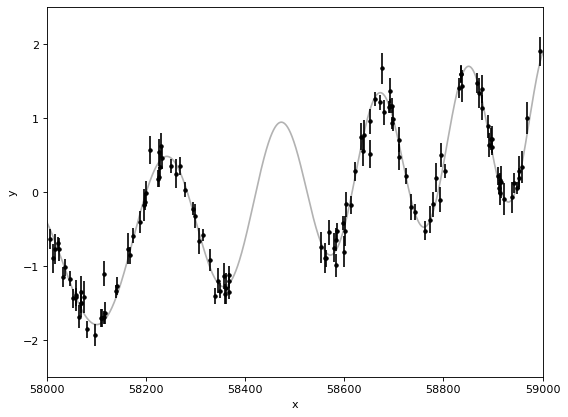

In [5]:
# let's simulate the data
# this is taken from the tinygp tutorial
np.random.seed(42)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  
# The input coordinates must be sorted
print('number of points: {}'.format(len(t)))
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 0+10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

t = t*100 + 58000
true_t = true_t*100 + 58000


plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(58000, 58000+10*100)
plt.ylim(-2.5, 2.5);

In [6]:
theta_init = {
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(1.0),
    "log_sigma": np.log(4.3),
    "log_alpha": np.log([1.0, 1.2]),
    "log_beta": np.log([1.2])
}

def create_alt_theta_init(theta_init):

    alt_theta_init = {
        "log_per_amp": np.random.normal(np.exp(theta_init['log_per_amp']),
                                        np.exp(theta_init['log_per_amp'])),
        "log_scale": np.random.normal(np.exp(theta_init['log_scale']),
                                        np.exp(theta_init['log_scale'])),
        "log_sigma": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma'])),
        "log_alpha": np.random.normal(np.exp(theta_init['log_alpha']),
                                        np.exp(theta_init['log_alpha'])),
        "log_beta": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma']))}
    
    return alt_theta_init


# 1. combination of carma and periodic
def build_gp(theta, t):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    per_amp = jnp.exp(theta["log_per_amp"])
    
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
    
    periodic_kernel = (
        per_amp
        * quasisep.Cosine(
            scale=jnp.exp(theta["log_scale"]),
            sigma=jnp.exp(theta["log_sigma"]),
        )
    )
    
    kernel = carma_kernel + periodic_kernel
    
    return GaussianProcess(kernel, t, diag=yerr, mean=0.0)

# 2. create loss function
@jax.jit
def neg_log_likelihood(theta, t, y):
    gp = build_gp(theta, t)
    return -gp.log_probability(y)

# 3. evaluate in situ
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: 162.81565860191517
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray([19.89866069, -5.613459  ], dtype=float64), 'log_beta': DeviceArray([-16.693369], dtype=float64), 'log_per_amp': DeviceArray(0.99985759, dtype=float64), 'log_scale': DeviceArray(-4163.05934207, dtype=float64), 'log_sigma': DeviceArray(1.99971519, dtype=float64)}


In [7]:
# 4. optimize
with suppress_stdout_stderr():
    solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
    soln = solver.run(theta_init, t=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 160.86432542315467


In [8]:
# print parameters
soln.params

{'log_alpha': DeviceArray([-0.00604484,  0.18557687], dtype=float64),
 'log_beta': DeviceArray([0.18559458], dtype=float64),
 'log_per_amp': DeviceArray(1.79132091, dtype=float64),
 'log_scale': DeviceArray(0.34451715, dtype=float64),
 'log_sigma': DeviceArray(1.4577379, dtype=float64)}

In [9]:
# loop to find best value from many init
# around 1min 40seconds

list_fun_val = []
for i in range(1000):
    alt_theta_init = create_alt_theta_init(theta_init)
    soln = solver.run(alt_theta_init, t=t, y=y)
    list_fun_val.append([soln.state.fun_val.item(),soln.params])
    # print(f"Final negative log likelihood: {soln.state.fun_val}")
    
arr_fun_val = np.array(list_fun_val)

best_fun_val = np.min(arr_fun_val[:,0])
best_par = arr_fun_val[arr_fun_val[:,0] == best_fun_val][0][1]

# 4. optimize again from the best res 
with suppress_stdout_stderr():
    solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
    soln = solver.run(best_par, t=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 44.207584896951545


<Figure size 1280x960 with 0 Axes>

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'x')

Text(0, 0.5, 'y')

(58000.0, 59000.0)

(-2.5, 2.5)

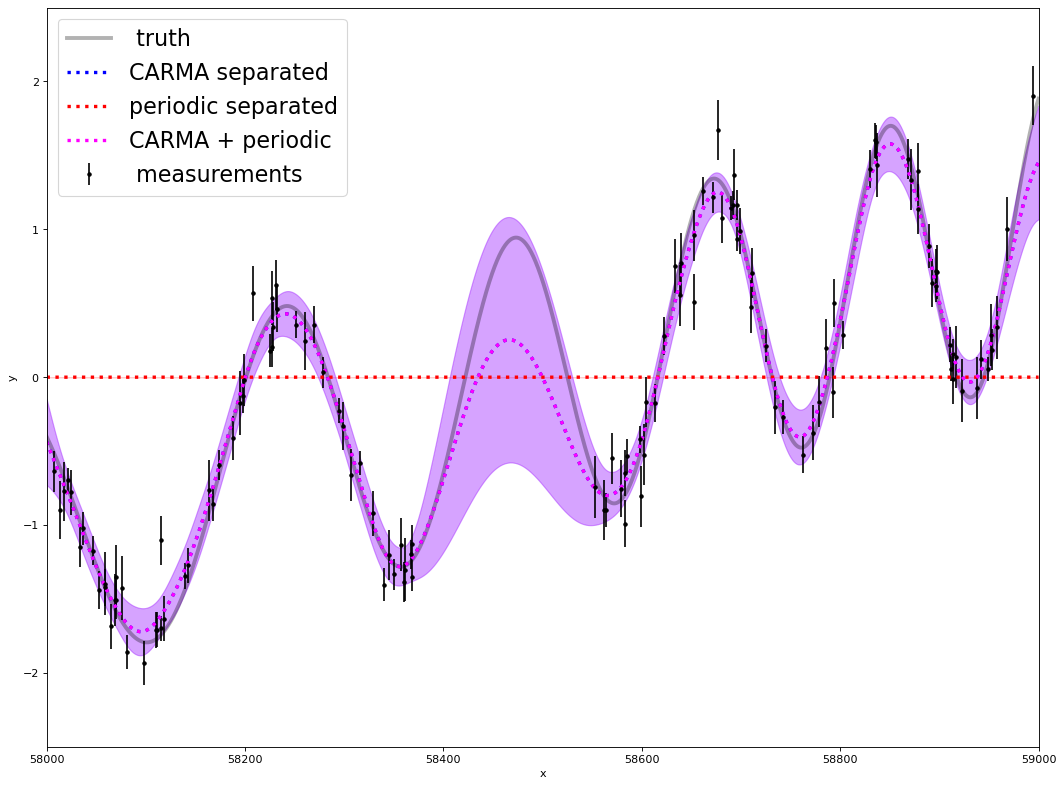

In [10]:
# define grid over which to evaluate
x = np.linspace(58000+0, 58000+10*100, 2000)

with suppress_stdout_stderr():
    gp = build_gp(soln.params, t)
    cond_gp = gp.condition(y, x).gp
    mu, var = cond_gp.loc, cond_gp.variance

    mu_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.loc
    var_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.variance

    mu_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.loc
    var_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.variance


plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(true_t, true_y, "k", lw=3.5, alpha=0.3, label = ' truth')
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label = ' measurements')

plt.plot(x, mu_carma, color="blue", ls=':',lw=3, label = 'CARMA separated')
plt.plot(x, mu_periodic, color="red", ls=':', lw=3, label = 'periodic separated')

plt.fill_between(x, mu_carma + np.sqrt(var_carma),
                 mu_carma- np.sqrt(var_carma), color="blue", alpha=0.2)
plt.fill_between(x, mu_periodic + np.sqrt(var_periodic),
                 mu_periodic - np.sqrt(var_periodic), color="red", alpha=0.2)

plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="magenta", alpha=0.2)
plt.plot(x, mu, color="magenta", lw=3, ls=':', label = 'CARMA + periodic')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(58000, 58000+10*100)
plt.ylim(-2.5, 2.5);
plt.legend(fontsize = 20)

# lsstseries case - NO

In [13]:
from lsstseries import Ensemble
from lsstseries.analysis.structurefunction2 import calc_sf2
from lsstseries.analysis.stetsonj import calc_stetson_J

import numpy as np
import pandas as pd

# import hipscat
# import dask.dataframe as dd
# from dask.distributed import Client
# import multiprocessing;multiprocessing.cpu_count()

In [14]:
ens = Ensemble()
ens = ens.from_parquet("/data/epyc/users/brantd/timeseries/ztf_testdata/8*.parquet",
                      id_col="ps1_objid",
                      time_col="mjd",
                      flux_col="mag",
                      err_col="magerr")

ens.dropna(1).prune(100)

/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43212 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39554
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:43212
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35202'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36769'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37336'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34697'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40372'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46010'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40337'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38140'
INFO:

In [15]:
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43212/status,
Dashboard: http://127.0.0.1:43212/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39554,Workers: 12
Dashboard: http://127.0.0.1:43212/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:35841,Total threads: 8
Dashboard: http://127.0.0.1:33799/status,Memory: 83.97 GiB
Nanny: tcp://127.0.0.1:35202,


In [16]:
# 1. combination of carma and periodic
def build_gp(theta, t):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    per_amp = jnp.exp(theta["log_per_amp"])
    
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
    
    periodic_kernel = (
        per_amp
        * quasisep.Cosine(
            scale=jnp.exp(theta["log_scale"]),
            sigma=jnp.exp(theta["log_sigma"]),
        )
    )
    
    kernel = carma_kernel + periodic_kernel
    
    return GaussianProcess(kernel, t, diag=yerr, mean=0.0)

# 2. create loss function
@jax.jit
def neg_log_likelihood(theta, t, y):
    gp = build_gp(theta, t)
    return -gp.log_probability(y)

# 3. evaluate in situ
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

In [17]:
# get any id
test_id = ens.head(1).index.values[0]
# create test timeseries
test_ts = ens.to_timeseries(test_id)
# the values need to be sorted in time
test_ts.data = test_ts.data.sort_values('mjd')
# get only one band
test_ts_r = test_ts.data[test_ts.data.index.get_level_values(0)=='r']


In [18]:
test_ts_r

mjd        mag    magerr band  num_obs
band index                                                
r    41     58369.50313  19.296867  0.074385    r      205
     42     58372.50346  19.291056  0.074073    r      205
     43     58375.50273  19.277573  0.073356    r      205
     44     58423.36147  19.339596  0.076707    r      205
     45     58423.36239  19.248087  0.071808    r      205
...                 ...        ...       ...  ...      ...
     136    59532.35993  19.555511  0.089389    r      205
     137    59537.37403  19.413792  0.080888    r      205
     138    59622.19209  19.484486  0.085045    r      205
     139    59624.17312  19.652134  0.095557    r      205
     140    59627.14932  19.476368  0.084560    r      205

[141 rows x 5 columns]

<ErrorbarContainer object of 3 artists>

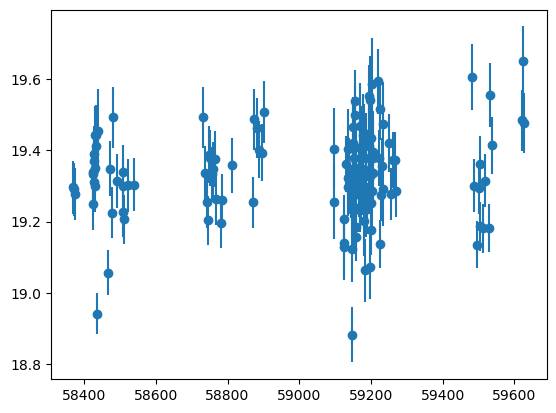

In [19]:
plt.errorbar(test_ts_r['mjd'].values, test_ts_r['mag'].values, yerr =  test_ts_r['magerr'].values, fmt="o")

In [20]:
theta_init = {
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(1.0),
    "log_sigma": np.log(4.3),
    "log_alpha": np.log([1.0, 1.2]),
    "log_beta": np.log([1.2])
}

def create_alt_theta_init(theta_init):

    alt_theta_init = {
        "log_per_amp": np.random.normal(np.exp(theta_init['log_per_amp']),
                                        np.exp(theta_init['log_per_amp'])),
        "log_scale": np.random.normal(np.exp(theta_init['log_scale']),
                                        np.exp(theta_init['log_scale'])),
        "log_sigma": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma'])),
        "log_alpha": np.random.normal(np.exp(theta_init['log_alpha']),
                                        np.exp(theta_init['log_alpha'])),
        "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma']))])}
    
    return alt_theta_init


# 1. combination of carma and periodic
def build_gp(theta, t, yerr):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    per_amp = jnp.exp(theta["log_per_amp"])
    
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
    
    periodic_kernel = (
        per_amp
        * quasisep.Cosine(
            scale=jnp.exp(theta["log_scale"]),
            sigma=jnp.exp(theta["log_sigma"]),
        )
    )
    
    kernel = carma_kernel + periodic_kernel
    
    return GaussianProcess(kernel, t, diag=yerr, mean=0.0)

# 2. create loss function
@jax.jit
def neg_log_likelihood(theta, t, y, yerr):
    gp = build_gp(theta, t, yerr)
    return -gp.log_probability(y)

# 3. evaluate in situ
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

In [21]:
print(f"Initial negative log likelihood: {obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)[0]}")

print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)[1]}")


Initial negative log likelihood: 2923.169802257817
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray([2155.2067498 , 1692.40265397], dtype=float64), 'log_beta': DeviceArray([-4346.45935547], dtype=float64), 'log_per_amp': DeviceArray(-1.40548473, dtype=float64), 'log_scale': DeviceArray(9605035.96452644, dtype=float64), 'log_sigma': DeviceArray(-2.81096947, dtype=float64)}


In [22]:
# timing
%time obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)
%time obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)
%time obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)
%timeit obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)

CPU times: user 3.98 ms, sys: 0 ns, total: 3.98 ms
Wall time: 2.68 ms
CPU times: user 3.05 ms, sys: 2.02 ms, total: 5.07 ms
Wall time: 3.72 ms
CPU times: user 858 µs, sys: 1.8 ms, total: 2.66 ms
Wall time: 2.02 ms
1.52 ms ± 48.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [23]:
test_id = ens.head(1).index.values[0]
test_ts = ens.to_timeseries(test_id)

# separation into 1d arrays
mjd = test_ts.data['mjd'].values
mag = test_ts.data['mag'].values
magerr = test_ts.data['magerr'].values
band = test_ts.data.index.get_level_values(0)


In [24]:
# repartition a single parquet file in order to get less lightcurves
ens = Ensemble()
ens = ens.from_parquet("/data/epyc/users/brantd/timeseries/ztf_testdata/82570690005091358.parquet",
                      id_col="ps1_objid",
                      time_col="mjd",
                      flux_col="mag",
                      err_col="magerr")
ens._data = ens._data.repartition(partition_size='1000KB').partitions[0:10]
ens.dropna(1).prune(5)
ens._data = ens._data.repartition(partition_size='1000KB').partitions[0:10]

/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42098 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:43151
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:42098
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45143'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36979'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35508'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36835'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44546'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46821'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40874'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38313'
INFO:

In [25]:
ens_comp = ens._data.compute()

In [26]:
# number of observations
# 118162 obs took 12 min with 10 worksers
# 11919 obs took 5.20 min with 10 worksers 
len(ens_comp)

59032

In [27]:
# number of lightcurves
len(np.unique(ens_comp.index))

761

In [28]:
# defining a function that can work with batch
def test_ts_obj(mjd, mag, magerr, band):

    # in which band was the observation taken
    band = band.values

    # hard coded that you analyze g-band
    mjd = mjd.values[band == 'g']
    mag = mag.values[band == 'g']
    magerr = magerr.values[band == 'g']
    if len(mjd) == 0:
        return 999

    # you need to sort the data to be in chronological order 
    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]
    
    res = obj(theta_init, mjd, mag, magerr)[0]    
    return res 

In [26]:
res_test = ens.batch(test_ts_obj, None, True, 'mjd', 'mag', 'magerr', 'band')

2023-03-20 11:21:20,746 - distributed.worker - WARNING - Compute Failed
Key:       ('lambda-7a74907743a8c98b4f523fca4b359163', 2)
Function:  subgraph_callable-a60d4e7f-436d-4e21-9dea-6412819b
args:      (                           mjd        mag    magerr band
ps1_objid                                               
80690684516332332  59142.43248  21.281952  0.186233    g
80690684516332332  59142.43295  20.809971  0.167565    g
80690684516332332  58378.48183  20.466909  0.201969    g
80690684516332332  58424.36211  20.466919  0.201970    g
80690684516332332  58426.39680  20.808304  0.232966    g
...                        ...        ...       ...  ...
80980681683290515  59222.24468  20.785378  0.166082    r
80980681683290515  59230.21303  20.660309  0.157632    r
80980681683290515  59255.12904  20.698217  0.160193    r
80980681683290515  59504.46503  20.736443  0.162776    r
80980681683290515  59517.42530  20.887276  0.172966    r

[1428457 rows x 4 columns],                    mjd  ma

TypeError: neg_log_likelihood() takes 3 positional arguments but 4 were given

INFO:distributed.core:Event loop was unresponsive in Nanny for 3.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

In [21]:
type(res_test)

pandas.core.series.Series

In [22]:
len(res_test)

1515

# Run one by one - NO

In [31]:
uniq_id = np.unique(ens_comp.index)

res_man = []
for i in tqdm(range(len(uniq_id[0:10]))):

    mjd = ens_comp[ens_comp.index == uniq_id[i]]['mjd'].values
    mag = ens_comp[ens_comp.index == uniq_id[i]]['mag'].values
    magerr = ens_comp[ens_comp.index == uniq_id[i]]['magerr'].values

    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]

    res_man.append(obj(theta_init, mjd, mag, magerr)[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.49s/it]


In [32]:
res_man[-1]

DeviceArray(14516.18080037, dtype=float64)

In [34]:
res_man


[DeviceArray(4465.67906814, dtype=float64),
 DeviceArray(7412.98752599, dtype=float64),
 DeviceArray(15304.88000368, dtype=float64),
 DeviceArray(8002.25524142, dtype=float64),
 DeviceArray(12410.52923534, dtype=float64),
 DeviceArray(9746.3930762, dtype=float64),
 DeviceArray(19883.3273383, dtype=float64),
 DeviceArray(12616.70613999, dtype=float64),
 DeviceArray(7530.05200916, dtype=float64),
 DeviceArray(14516.18080037, dtype=float64)]

In [35]:
neg_log_likelihood

<CompiledFunction of <function neg_log_likelihood at 0x7fc310525120>>

In [36]:
obj

<CompiledFunction of <function neg_log_likelihood at 0x7fc33025f370>>

In [ ]:
# Recut ZTF 

# Recut ZTF 

In [23]:
# takes between 10 to 40 seconds to load
catalog = pd.read_parquet('/data3/epyc/data3/hipscat/catalogs/ztf_dr14_explode/Norder1/Npix33/catalog.parquet')
object = pd.read_parquet('/data3/epyc/data3/hipscat/catalogs/ztf_dr14_explode/Norder1/Npix33/object.parquet')
source = pd.read_parquet('/data3/epyc/data3/hipscat/catalogs/ztf_dr14_explode/Norder1/Npix33/source.parquet')

In [24]:
catalog.shape
object.shape
source.shape

(64138932, 19)

(982531, 12)

(64138932, 10)

In [25]:
catalog

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,catflags,fieldID,mag,maggerr,mjd,rcID,band
0,71150579853858093,57.985352,-30.701809,19.748899,19.6168,19.303301,0,10,0,NaN,18.922858,NaN,-32768,1247,18.962080,0.081336,58439.38730,5,r
1,71150579853858093,57.985352,-30.701809,19.748899,19.6168,19.303301,0,10,0,NaN,18.922858,NaN,0,1247,18.842800,0.074530,59153.36653,5,r
2,71150579853858093,57.985352,-30.701809,19.748899,19.6168,19.303301,0,10,0,NaN,18.922858,NaN,0,1247,19.019619,0.084809,59176.30963,5,r
3,71150579853858093,57.985352,-30.701809,19.748899,19.6168,19.303301,0,10,0,NaN,18.922858,NaN,0,1247,19.058514,0.087227,59176.31010,5,r
4,71150579853858093,57.985352,-30.701809,19.748899,19.6168,19.303301,0,10,0,NaN,18.922858,NaN,-1,1247,18.567379,0.060815,59181.32123,5,r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64138927,84620675022297947,67.502203,-19.476937,21.281500,21.0012,20.901400,19,53,0,21.116718,20.756148,NaN,0,303,21.305876,0.302479,59518.32459,1,r
64138928,84620675022297947,67.502203,-19.476937,21.281500,21.0012,20.901400,19,53,0,21.116718,20.756148,NaN,0,303,21.016495,0.271204,59523.29531,1,r
64138929,84620675022297947,67.502203,-19.476937,21.281500,21.0012,20.901400,19,53,0,21.116718,20.756148,NaN,0,303,20.730957,0.240345,59524.36351,1,r
64138930,84620675022297947,67.502203,-19.476937,21.281500,21.0012,20.901400,19,53,0,21.116718,20.756148,NaN,0,303,20.554796,0.221307,59624.17445,1,r


In [26]:
object

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i
0,71150579853858093,57.985352,-30.701809,19.748899,19.616800,19.303301,0,10,0,NaN,18.922858,NaN
1,71150580897018761,58.089706,-30.701355,20.878300,-999.000000,20.376801,0,3,0,NaN,20.331991,NaN
2,71150582167248993,58.216713,-30.701073,21.564800,21.044701,20.671499,0,2,0,NaN,20.215671,NaN
3,71150582170049337,58.216713,-30.701073,21.754999,-999.000000,-999.000000,0,2,0,NaN,20.215671,NaN
4,71150642260279229,64.225967,-30.700874,20.066299,19.034300,18.556000,4,0,0,19.827822,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
982526,84610674997760612,67.499825,-19.491512,22.257900,21.786301,21.496500,0,2,0,NaN,20.876813,NaN
982527,84610675003571627,67.500383,-19.490579,21.727699,21.195400,20.911800,6,57,0,20.820186,20.701326,NaN
982528,84610675136421586,67.513697,-19.490607,19.223000,18.446199,18.124701,287,336,0,19.247896,18.371590,NaN
982529,84620674927697007,67.492832,-19.477761,20.339701,21.375200,21.056000,0,35,0,NaN,20.694399,NaN


In [27]:
source

,ps1_objid,ra,dec,catflags,fieldID,mag,maggerr,mjd,rcID,band
213782,71150579853858093,57.985352,-30.701809,-32768,1247,18.962080,0.081336,58439.38730,5,r
213782,71150579853858093,57.985352,-30.701809,0,1247,18.842800,0.074530,59153.36653,5,r
213782,71150579853858093,57.985352,-30.701809,0,1247,19.019619,0.084809,59176.30963,5,r
213782,71150579853858093,57.985352,-30.701809,0,1247,19.058514,0.087227,59176.31010,5,r
213782,71150579853858093,57.985352,-30.701809,-1,1247,18.567379,0.060815,59181.32123,5,r
...,...,...,...,...,...,...,...,...,...,...
979921,84620675022297947,67.502203,-19.476937,0,303,21.305876,0.302479,59518.32459,1,r
979921,84620675022297947,67.502203,-19.476937,0,303,21.016495,0.271204,59523.29531,1,r
979921,84620675022297947,67.502203,-19.476937,0,303,20.730957,0.240345,59524.36351,1,r
979921,84620675022297947,67.502203,-19.476937,0,303,20.554796,0.221307,59624.17445,1,r


# Trying to run on source data from ZTF - SHOW

In [33]:
source.columns

Index(['ps1_objid', 'ra', 'dec', 'catflags', 'fieldID', 'mag', 'maggerr',
       'mjd', 'rcID', 'band'],
      dtype='object')

In [36]:
# takes between 1min 25sec & 1min 45sec
ens = Ensemble()
ens = ens.from_parquet('/data3/epyc/data3/hipscat/catalogs/ztf_dr14_explode/Norder1/Npix33/source.parquet',
                      id_col="ps1_objid",
                      time_col="mjd",
                      flux_col="mag",
                      err_col="magerr")

# keep only lightcurves with more than 100 observations 
# I dont know what dropna exactly is
ens.dropna(1).prune(100)
ens._data = ens._data.repartition(partition_size='1000KB')

/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33935 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:40836
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:33935
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39023'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37667'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35655'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36605'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36621'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45371'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45407'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38874'
INFO:

In [37]:
theta_init = {
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(1.0),
    "log_sigma": np.log(4.3),
    "log_alpha": np.log([1.0, 1.2]),
    "log_beta": np.log([1.2])
}

def create_alt_theta_init(theta_init):

    alt_theta_init = {
        "log_per_amp": np.random.normal(np.exp(theta_init['log_per_amp']),
                                        np.exp(theta_init['log_per_amp'])),
        "log_scale": np.random.normal(np.exp(theta_init['log_scale']),
                                        np.exp(theta_init['log_scale'])),
        "log_sigma": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma'])),
        "log_alpha": np.random.normal(np.exp(theta_init['log_alpha']),
                                        np.exp(theta_init['log_alpha'])),
        "log_beta": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma']))}
    
    return alt_theta_init


# 1. combination of carma and periodic
def build_gp(theta, t, yerr):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    per_amp = jnp.exp(theta["log_per_amp"])
    
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
    
    periodic_kernel = (
        per_amp
        * quasisep.Cosine(
            scale=jnp.exp(theta["log_scale"]),
            sigma=jnp.exp(theta["log_sigma"]),
        )
    )
    
    kernel = carma_kernel + periodic_kernel
    
    return GaussianProcess(kernel, t, diag=yerr, mean=0.0)

# 2. create loss function
@jax.jit
def neg_log_likelihood(theta, t, y, yerr):
    gp = build_gp(theta, t, yerr)
    return -gp.log_probability(y)

# 3. evaluate in situ
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

In [38]:
# computed in order to see the data
# between 1min 33sec and 4min 45sec
ens_comp = ens._data.compute()

INFO:distributed.core:Event loop was unresponsive in Nanny for 3.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

In [41]:
ens_comp.shape

(50154450, 10)

In [42]:
%%time
# This will run on first 10 objects

uniq_id = np.unique(ens_comp.index)

res_man = []
for i in tqdm(uniq_id[0:10]):

    mjd = ens_comp[ens_comp.index == i]['mjd'].values
    mag = ens_comp[ens_comp.index == i]['mag'].values
    magerr = ens_comp[ens_comp.index == i]['maggerr'].values

    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]

    res_man.append(obj(theta_init, mjd, mag, magerr)[0])

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

CPU times: user 5.55 s, sys: 2.75 s, total: 8.3 s
Wall time: 5.37 s


In [24]:
"""
Pickling experiment - that does not keep compilation

import pickle
import cloudpickle

with open("jit_fun.cloudpickle", "wb") as out:
  cloudpickle.dump(obj, out)

with open("jit_fun.cloudpickle",'rb') as out:
    obj_unpickled = pickle.load(out)
    
%%time 
uniq_id = np.unique(ens_comp.index)

res_man = []
for i in tqdm(range(len(uniq_id[0:10]))):

    mjd = ens_comp[ens_comp.index == uniq_id[i]]['mjd'].values
    mag = ens_comp[ens_comp.index == uniq_id[i]]['mag'].values
    magerr = ens_comp[ens_comp.index == uniq_id[i]]['maggerr'].values
    print(len(mjd))
    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]

    res_man.append(obj_unpickled(theta_init, mjd, mag, magerr)[0])
    
"""

'\nPickling experiment - that does not keep compilation\n\nimport pickle\nimport cloudpickle\n\nwith open("jit_fun.cloudpickle", "wb") as out:\n  cloudpickle.dump(obj, out)\n\nwith open("jit_fun.cloudpickle",\'rb\') as out:\n    obj_unpickled = pickle.load(out)\n    \n%%time \nuniq_id = np.unique(ens_comp.index)\n\nres_man = []\nfor i in tqdm(range(len(uniq_id[0:10]))):\n\n    mjd = ens_comp[ens_comp.index == uniq_id[i]][\'mjd\'].values\n    mag = ens_comp[ens_comp.index == uniq_id[i]][\'mag\'].values\n    magerr = ens_comp[ens_comp.index == uniq_id[i]][\'maggerr\'].values\n    print(len(mjd))\n    sort_arr = np.argsort(mjd)\n    mjd = mjd[sort_arr]\n    mag = mag[sort_arr]\n    magerr = magerr[sort_arr]\n\n    res_man.append(obj_unpickled(theta_init, mjd, mag, magerr)[0])\n    \n'

# Alternative idea - large ens - SHOW

In [68]:
# alternative idea
# see the length of curves on which you will operate
# compile (evaluate once; in future pre-compile)ens

In [43]:
index_count = pd.Index(ens_comp.index).value_counts()
len_lcs = np.unique(index_count.values)

In [44]:
# There are 944 different lengths in this sample
len_lcs.shape

(944,)

In [82]:
# this will run through all possibilites 
# 15 min for 184 combos
# 43.5 min for 900

"""
for l in tqdm(len_lcs):
    mjd = np.arange(0,l, dtype='float64')
    mag = np.arange(0,l, dtype='float32')
    magerr = np.copy(mag)

    obj(theta_init, mjd, mag, magerr)[0]
"""

  0%|                                                                                                           | 0/900 [00:00<?, ?it/s]

DeviceArray(1853.60735316, dtype=float64)

DeviceArray(1890.04889474, dtype=float64)

DeviceArray(1926.85194209, dtype=float64)

DeviceArray(1964.01663897, dtype=float64)

  0%|▍                                                                                                  | 4/900 [00:00<00:24, 37.13it/s]

DeviceArray(2001.54312776, dtype=float64)

DeviceArray(2039.43154946, dtype=float64)

DeviceArray(2077.6820437, dtype=float64)

DeviceArray(2116.29474878, dtype=float64)

DeviceArray(2155.2698017, dtype=float64)

DeviceArray(2194.60733816, dtype=float64)

DeviceArray(2234.30749261, dtype=float64)

DeviceArray(2274.37039822, dtype=float64)

DeviceArray(2314.79618696, dtype=float64)

Traced<ShapedArray(float64[113])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(2355.5849896, dtype=float64)

  2%|█▌                                                                                                | 14/900 [00:03<04:11,  3.52it/s]

DeviceArray(2396.7369357, dtype=float64)

DeviceArray(2438.25215367, dtype=float64)

DeviceArray(2480.13077076, dtype=float64)

DeviceArray(2522.37291311, dtype=float64)

Traced<ShapedArray(float64[118])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(2564.97870573, dtype=float64)

  2%|██                                                                                                | 19/900 [00:06<06:05,  2.41it/s]

DeviceArray(2607.94827253, dtype=float64)

DeviceArray(2651.28173637, dtype=float64)

DeviceArray(2694.97921901, dtype=float64)

DeviceArray(2739.04084121, dtype=float64)

DeviceArray(2783.46672266, dtype=float64)

DeviceArray(2828.25698207, dtype=float64)

Traced<ShapedArray(float64[125])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(2873.41173714, dtype=float64)

  3%|██▊                                                                                               | 26/900 [00:10<07:03,  2.07it/s]

DeviceArray(2918.93110457, dtype=float64)

DeviceArray(2964.81520012, dtype=float64)

DeviceArray(3011.06413858, dtype=float64)

DeviceArray(3057.67803381, dtype=float64)

DeviceArray(3104.65699874, dtype=float64)

DeviceArray(3152.00114539, dtype=float64)

DeviceArray(3199.71058488, dtype=float64)

DeviceArray(3247.78542744, dtype=float64)

DeviceArray(3296.22578243, dtype=float64)

DeviceArray(3345.03175835, dtype=float64)

DeviceArray(3394.20346285, dtype=float64)

DeviceArray(3443.74100275, dtype=float64)

DeviceArray(3493.64448404, dtype=float64)

DeviceArray(3543.9140119, dtype=float64)

DeviceArray(3594.54969069, dtype=float64)

DeviceArray(3645.551624, dtype=float64)

Traced<ShapedArray(float64[142])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(3696.91991463, dtype=float64)

  5%|████▋                                                                                             | 43/900 [00:15<05:06,  2.80it/s]

DeviceArray(3748.65466462, dtype=float64)

DeviceArray(3800.75597524, dtype=float64)

DeviceArray(3853.22394701, dtype=float64)

DeviceArray(3906.05867971, dtype=float64)

DeviceArray(3959.26027241, dtype=float64)

DeviceArray(4012.82882344, dtype=float64)

DeviceArray(4066.76443042, dtype=float64)

DeviceArray(4121.06719028, dtype=float64)

DeviceArray(4175.73719924, dtype=float64)

DeviceArray(4230.77455286, dtype=float64)

DeviceArray(4286.17934601, dtype=float64)

DeviceArray(4341.95167291, dtype=float64)

DeviceArray(4398.09162709, dtype=float64)

DeviceArray(4454.59930146, dtype=float64)

Traced<ShapedArray(float64[157])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(4511.47478829, dtype=float64)

  6%|██████▎                                                                                           | 58/900 [00:19<04:18,  3.26it/s]

DeviceArray(4568.7181792, dtype=float64)

DeviceArray(4626.3295652, dtype=float64)

DeviceArray(4684.30903667, dtype=float64)

DeviceArray(4742.65668338, dtype=float64)

Traced<ShapedArray(float64[162])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(4801.37259452, dtype=float64)

  7%|██████▊                                                                                           | 63/900 [00:22<05:12,  2.68it/s]

DeviceArray(4860.45685865, dtype=float64)

Traced<ShapedArray(float64[164])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(4919.90956378, dtype=float64)

  7%|███████                                                                                           | 65/900 [00:25<06:40,  2.09it/s]

DeviceArray(4979.7307973, dtype=float64)

Traced<ShapedArray(float64[166])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(5039.92064607, dtype=float64)

  7%|███████▎                                                                                          | 67/900 [00:28<08:21,  1.66it/s]

DeviceArray(5100.47919634, dtype=float64)

DeviceArray(5161.40653382, dtype=float64)

DeviceArray(5222.70274368, dtype=float64)

DeviceArray(5284.36791051, dtype=float64)

DeviceArray(5346.40211839, dtype=float64)

DeviceArray(5408.80545085, dtype=float64)

DeviceArray(5471.57799089, dtype=float64)

DeviceArray(5534.719821, dtype=float64)

DeviceArray(5598.23102313, dtype=float64)

DeviceArray(5662.11167875, dtype=float64)

DeviceArray(5726.36186881, dtype=float64)

DeviceArray(5790.98167375, dtype=float64)

DeviceArray(5855.97117353, dtype=float64)

DeviceArray(5921.33044762, dtype=float64)

DeviceArray(5987.05957502, dtype=float64)

DeviceArray(6053.15863422, dtype=float64)

DeviceArray(6119.62770327, dtype=float64)

DeviceArray(6186.46685973, dtype=float64)

DeviceArray(6253.67618072, dtype=float64)

 10%|█████████▎                                                                                        | 86/900 [00:29<03:17,  4.12it/s]

DeviceArray(6321.25574289, dtype=float64)

DeviceArray(6389.20562243, dtype=float64)

DeviceArray(6457.52589511, dtype=float64)

DeviceArray(6526.21663622, dtype=float64)

DeviceArray(6595.27792065, dtype=float64)

DeviceArray(6664.70982283, dtype=float64)

DeviceArray(6734.51241677, dtype=float64)

DeviceArray(6804.68577606, dtype=float64)

DeviceArray(6875.22997388, dtype=float64)

Traced<ShapedArray(float64[195])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(6946.14508296, dtype=float64)

 11%|██████████▍                                                                                       | 96/900 [00:33<04:00,  3.34it/s]

DeviceArray(7017.43117566, dtype=float64)

DeviceArray(7089.08832391, dtype=float64)

DeviceArray(7161.11659924, dtype=float64)

DeviceArray(7233.51607278, dtype=float64)

DeviceArray(7306.28681528, dtype=float64)

DeviceArray(7379.42889708, dtype=float64)

DeviceArray(7452.94238815, dtype=float64)

Traced<ShapedArray(float64[203])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(7526.82735806, dtype=float64)

 12%|███████████▏                                                                                     | 104/900 [00:36<04:31,  2.93it/s]

DeviceArray(7601.08387602, dtype=float64)

DeviceArray(7675.71201085, dtype=float64)

DeviceArray(7750.71183101, dtype=float64)

Traced<ShapedArray(float64[207])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(7826.08340459, dtype=float64)

 12%|███████████▋                                                                                     | 108/900 [00:40<05:33,  2.38it/s]

DeviceArray(7901.8267993, dtype=float64)

DeviceArray(7977.94208251, dtype=float64)

DeviceArray(8054.42932122, dtype=float64)

DeviceArray(8131.28858209, dtype=float64)

DeviceArray(8208.51993141, dtype=float64)

Traced<ShapedArray(float64[213])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(8286.12343515, dtype=float64)

 13%|████████████▎                                                                                    | 114/900 [00:43<05:58,  2.19it/s]

Traced<ShapedArray(float64[214])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(8364.0991589, dtype=float64)

DeviceArray(8442.44716795, dtype=float64)

 13%|████████████▌                                                                                    | 116/900 [00:46<07:34,  1.72it/s]

DeviceArray(8521.16752722, dtype=float64)

DeviceArray(8600.26030131, dtype=float64)

DeviceArray(8679.72555449, dtype=float64)

DeviceArray(8759.5633507, dtype=float64)

DeviceArray(8839.77375357, dtype=float64)

DeviceArray(8920.35682637, dtype=float64)

DeviceArray(9001.31263208, dtype=float64)

DeviceArray(9082.64123338, dtype=float64)

 14%|█████████████▎                                                                                   | 124/900 [00:47<04:42,  2.75it/s]

DeviceArray(9164.34269259, dtype=float64)

Traced<ShapedArray(float64[225])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(9246.41707177, dtype=float64)

DeviceArray(9328.86443263, dtype=float64)

DeviceArray(9411.6848366, dtype=float64)

 14%|█████████████▊                                                                                   | 128/900 [00:51<06:47,  1.90it/s]

DeviceArray(9494.87834481, dtype=float64)

Traced<ShapedArray(float64[229])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(9578.44501808, dtype=float64)

Traced<ShapedArray(float64[230])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(9662.38491694, dtype=float64)

 15%|██████████████                                                                                   | 131/900 [00:58<11:24,  1.12it/s]

Traced<ShapedArray(float64[231])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(9746.69810162, dtype=float64)

DeviceArray(9831.38463206, dtype=float64)

 15%|██████████████▎                                                                                  | 133/900 [01:02<13:01,  1.02s/it]

DeviceArray(9916.44456792, dtype=float64)

DeviceArray(10001.87796857, dtype=float64)

DeviceArray(10087.68489309, dtype=float64)

DeviceArray(10173.86540028, dtype=float64)

DeviceArray(10260.41954867, dtype=float64)

DeviceArray(10347.34739651, dtype=float64)

Traced<ShapedArray(float64[239])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(10434.64900177, dtype=float64)

 16%|███████████████                                                                                  | 140/900 [01:05<10:01,  1.26it/s]

Traced<ShapedArray(float64[240])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(10522.32442215, dtype=float64)

 16%|███████████████▏                                                                                 | 141/900 [01:09<12:41,  1.00s/it]

DeviceArray(10610.37371509, dtype=float64)

DeviceArray(10698.79693776, dtype=float64)

DeviceArray(10787.59414706, dtype=float64)

DeviceArray(10876.76539963, dtype=float64)

DeviceArray(10966.31075185, dtype=float64)

DeviceArray(11056.23025984, dtype=float64)

Traced<ShapedArray(float64[247])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(11146.52397946, dtype=float64)

 16%|███████████████▉                                                                                 | 148/900 [01:13<10:30,  1.19it/s]

DeviceArray(11237.19196634, dtype=float64)

DeviceArray(11328.23427582, dtype=float64)

DeviceArray(11419.65096303, dtype=float64)

Traced<ShapedArray(float64[251])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(11511.44208282, dtype=float64)

 17%|████████████████▍                                                                                | 152/900 [01:17<11:07,  1.12it/s]

DeviceArray(11603.60768982, dtype=float64)

DeviceArray(11696.14783839, dtype=float64)

DeviceArray(11789.06258268, dtype=float64)

DeviceArray(11882.35197657, dtype=float64)

DeviceArray(11976.01607373, dtype=float64)

DeviceArray(12070.05492757, dtype=float64)

DeviceArray(12164.46859127, dtype=float64)

DeviceArray(12259.25711781, dtype=float64)

DeviceArray(12354.42055989, dtype=float64)

Traced<ShapedArray(float64[261])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(12449.95897002, dtype=float64)

 18%|█████████████████▍                                                                               | 162/900 [01:21<07:35,  1.62it/s]

DeviceArray(12545.87240046, dtype=float64)

Traced<ShapedArray(float64[263])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(12642.16090327, dtype=float64)

 18%|█████████████████▋                                                                               | 164/900 [01:25<09:31,  1.29it/s]

DeviceArray(12738.82453026, dtype=float64)

DeviceArray(12835.86333304, dtype=float64)

Traced<ShapedArray(float64[266])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(12933.27736299, dtype=float64)

 19%|█████████████████▉                                                                               | 167/900 [01:28<10:24,  1.17it/s]

Traced<ShapedArray(float64[267])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(13031.06667127, dtype=float64)

 19%|██████████████████                                                                               | 168/900 [01:33<15:00,  1.23s/it]

Traced<ShapedArray(float64[268])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(13129.23130883, dtype=float64)

 19%|██████████████████▏                                                                              | 169/900 [01:36<18:01,  1.48s/it]

DeviceArray(13227.77132641, dtype=float64)

DeviceArray(13326.68677453, dtype=float64)

DeviceArray(13425.97770349, dtype=float64)

DeviceArray(13525.64416341, dtype=float64)

DeviceArray(13625.68620416, dtype=float64)

DeviceArray(13726.10387545, dtype=float64)

DeviceArray(13826.89722674, dtype=float64)

DeviceArray(13928.06630733, dtype=float64)

DeviceArray(14029.61116628, dtype=float64)

DeviceArray(14131.53185247, dtype=float64)

DeviceArray(14233.82841458, dtype=float64)

Traced<ShapedArray(float64[280])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(14336.5009011, dtype=float64)

 20%|███████████████████▌                                                                             | 181/900 [01:41<08:45,  1.37it/s]

DeviceArray(14439.54936031, dtype=float64)

DeviceArray(14542.9738403, dtype=float64)

Traced<ShapedArray(float64[283])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(14646.77438896, dtype=float64)

 20%|███████████████████▊                                                                             | 184/900 [01:44<09:48,  1.22it/s]

DeviceArray(14750.95105401, dtype=float64)

DeviceArray(14855.50388296, dtype=float64)

DeviceArray(14960.43292314, dtype=float64)

DeviceArray(15065.73822169, dtype=float64)

Traced<ShapedArray(float64[288])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(15171.41982556, dtype=float64)

 21%|████████████████████▎                                                                            | 189/900 [01:48<09:30,  1.25it/s]

DeviceArray(15277.47778153, dtype=float64)

Traced<ShapedArray(float64[290])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(15383.91213618, dtype=float64)

 21%|████████████████████▌                                                                            | 191/900 [01:52<11:40,  1.01it/s]

DeviceArray(15490.72293592, dtype=float64)

DeviceArray(15597.91022697, dtype=float64)

Traced<ShapedArray(float64[293])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(15705.47405538, dtype=float64)

 22%|████████████████████▉                                                                            | 194/900 [01:55<12:02,  1.02s/it]

Traced<ShapedArray(float64[294])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(15813.41446701, dtype=float64)

 22%|█████████████████████                                                                            | 195/900 [01:59<14:50,  1.26s/it]

DeviceArray(15921.73150756, dtype=float64)

DeviceArray(16030.42522253, dtype=float64)

DeviceArray(16139.49565728, dtype=float64)

DeviceArray(16248.94285696, dtype=float64)

Traced<ShapedArray(float64[299])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(16358.76686657, dtype=float64)

 22%|█████████████████████▌                                                                           | 200/900 [02:02<11:35,  1.01it/s]

DeviceArray(16468.96773093, dtype=float64)

Traced<ShapedArray(float64[301])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(16579.54549471, dtype=float64)

 22%|█████████████████████▊                                                                           | 202/900 [02:06<13:39,  1.17s/it]

Traced<ShapedArray(float64[302])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(16690.50020238, dtype=float64)

 23%|█████████████████████▉                                                                           | 203/900 [02:10<17:19,  1.49s/it]

DeviceArray(16801.83189827, dtype=float64)

Traced<ShapedArray(float64[304])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(16913.54062653, dtype=float64)

 23%|██████████████████████                                                                           | 205/900 [02:14<19:09,  1.65s/it]

DeviceArray(17025.62643115, dtype=float64)

DeviceArray(17138.08935595, dtype=float64)

Traced<ShapedArray(float64[307])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(17250.92944459, dtype=float64)

 23%|██████████████████████▍                                                                          | 208/900 [02:18<18:17,  1.59s/it]

DeviceArray(17364.14674058, dtype=float64)

Traced<ShapedArray(float64[309])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(17477.74128726, dtype=float64)

 23%|██████████████████████▋                                                                          | 210/900 [02:22<18:49,  1.64s/it]

DeviceArray(17591.7131278, dtype=float64)

DeviceArray(17706.06230522, dtype=float64)

DeviceArray(17820.7888624, dtype=float64)

DeviceArray(17935.89284204, dtype=float64)

Traced<ShapedArray(float64[314])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(18051.3742867, dtype=float64)

 24%|███████████████████████▏                                                                         | 215/900 [02:25<13:32,  1.19s/it]

DeviceArray(18167.23323876, dtype=float64)

DeviceArray(18283.46974049, dtype=float64)

DeviceArray(18400.08383397, dtype=float64)

DeviceArray(18517.07556116, dtype=float64)

Traced<ShapedArray(float64[319])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(18634.44496383, dtype=float64)

 24%|███████████████████████▋                                                                         | 220/900 [02:29<11:23,  1.01s/it]

Traced<ShapedArray(float64[320])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(18752.19208363, dtype=float64)

 25%|███████████████████████▊                                                                         | 221/900 [02:33<14:47,  1.31s/it]

Traced<ShapedArray(float64[321])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(18870.31696207, dtype=float64)

 25%|███████████████████████▉                                                                         | 222/900 [02:36<17:25,  1.54s/it]

DeviceArray(18988.81964048, dtype=float64)

Traced<ShapedArray(float64[323])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(19107.70016008, dtype=float64)

 25%|████████████████████████▏                                                                        | 224/900 [02:39<17:36,  1.56s/it]

Traced<ShapedArray(float64[324])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(19226.95856192, dtype=float64)

 25%|████████████████████████▎                                                                        | 225/900 [02:43<21:39,  1.92s/it]

DeviceArray(19346.5948869, dtype=float64)

Traced<ShapedArray(float64[326])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(19466.60917581, dtype=float64)

 25%|████████████████████████▍                                                                        | 227/900 [02:47<22:41,  2.02s/it]

DeviceArray(19587.00146927, dtype=float64)

Traced<ShapedArray(float64[328])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(19707.77180775, dtype=float64)

 25%|████████████████████████▋                                                                        | 229/900 [02:52<24:21,  2.18s/it]

Traced<ShapedArray(float64[329])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(19828.92023162, dtype=float64)

 26%|████████████████████████▊                                                                        | 230/900 [02:57<28:07,  2.52s/it]

Traced<ShapedArray(float64[330])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(19950.44678107, dtype=float64)

 26%|████████████████████████▉                                                                        | 231/900 [03:00<30:22,  2.72s/it]

Traced<ShapedArray(float64[331])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20072.35149617, dtype=float64)

 26%|█████████████████████████                                                                        | 232/900 [03:03<31:22,  2.82s/it]

Traced<ShapedArray(float64[332])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20194.63441684, dtype=float64)

 26%|█████████████████████████                                                                        | 233/900 [03:07<33:45,  3.04s/it]

Traced<ShapedArray(float64[333])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20317.29558288, dtype=float64)

 26%|█████████████████████████▏                                                                       | 234/900 [03:11<36:54,  3.32s/it]

Traced<ShapedArray(float64[334])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20440.33503394, dtype=float64)

 26%|█████████████████████████▎                                                                       | 235/900 [03:15<38:00,  3.43s/it]

Traced<ShapedArray(float64[335])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20563.75280955, dtype=float64)

 26%|█████████████████████████▍                                                                       | 236/900 [03:18<38:09,  3.45s/it]

Traced<ShapedArray(float64[336])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20687.54894908, dtype=float64)

 26%|█████████████████████████▌                                                                       | 237/900 [03:22<40:27,  3.66s/it]

Traced<ShapedArray(float64[337])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20811.72349178, dtype=float64)

 26%|█████████████████████████▋                                                                       | 238/900 [03:26<38:53,  3.53s/it]

Traced<ShapedArray(float64[338])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20936.27647678, dtype=float64)

 27%|█████████████████████████▊                                                                       | 239/900 [03:29<39:00,  3.54s/it]

Traced<ShapedArray(float64[339])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(21061.20794307, dtype=float64)

 27%|█████████████████████████▊                                                                       | 240/900 [03:33<40:26,  3.68s/it]

Traced<ShapedArray(float64[340])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(21186.51792948, dtype=float64)

 27%|█████████████████████████▉                                                                       | 241/900 [03:37<39:43,  3.62s/it]

Traced<ShapedArray(float64[341])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(21312.20647476, dtype=float64)

 27%|██████████████████████████                                                                       | 242/900 [03:41<40:33,  3.70s/it]

Traced<ShapedArray(float64[342])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(21438.27361749, dtype=float64)

 27%|██████████████████████████▏                                                                      | 243/900 [03:45<41:50,  3.82s/it]

Traced<ShapedArray(float64[343])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(21564.71939613, dtype=float64)

 27%|██████████████████████████▎                                                                      | 244/900 [03:48<39:20,  3.60s/it]

Traced<ShapedArray(float64[344])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(21691.54384904, dtype=float64)

 27%|██████████████████████████▍                                                                      | 245/900 [03:52<39:49,  3.65s/it]

Traced<ShapedArray(float64[345])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(21818.74701441, dtype=float64)

 27%|██████████████████████████▌                                                                      | 246/900 [03:55<39:43,  3.64s/it]

Traced<ShapedArray(float64[346])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(21946.32893033, dtype=float64)

 27%|██████████████████████████▌                                                                      | 247/900 [03:58<38:31,  3.54s/it]

Traced<ShapedArray(float64[347])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22074.28963476, dtype=float64)

 28%|██████████████████████████▋                                                                      | 248/900 [04:02<39:09,  3.60s/it]

Traced<ShapedArray(float64[348])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22202.62916554, dtype=float64)

 28%|██████████████████████████▊                                                                      | 249/900 [04:06<39:37,  3.65s/it]

Traced<ShapedArray(float64[349])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22331.34756036, dtype=float64)

 28%|██████████████████████████▉                                                                      | 250/900 [04:09<38:23,  3.54s/it]

Traced<ShapedArray(float64[350])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22460.44485682, dtype=float64)

 28%|███████████████████████████                                                                      | 251/900 [04:14<41:16,  3.82s/it]

Traced<ShapedArray(float64[351])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22589.92109238, dtype=float64)

 28%|███████████████████████████▏                                                                     | 252/900 [04:17<40:04,  3.71s/it]

Traced<ShapedArray(float64[352])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22719.77630438, dtype=float64)

 28%|███████████████████████████▎                                                                     | 253/900 [04:21<40:02,  3.71s/it]

Traced<ShapedArray(float64[353])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22850.01053004, dtype=float64)

 28%|███████████████████████████▍                                                                     | 254/900 [04:24<38:17,  3.56s/it]

Traced<ShapedArray(float64[354])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22980.62380645, dtype=float64)

 28%|███████████████████████████▍                                                                     | 255/900 [04:28<38:02,  3.54s/it]

Traced<ShapedArray(float64[355])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23111.6161706, dtype=float64)

 28%|███████████████████████████▌                                                                     | 256/900 [04:32<42:07,  3.93s/it]

Traced<ShapedArray(float64[356])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23242.98765935, dtype=float64)

 29%|███████████████████████████▋                                                                     | 257/900 [04:37<43:46,  4.08s/it]

Traced<ShapedArray(float64[357])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23374.73830943, dtype=float64)

 29%|███████████████████████████▊                                                                     | 258/900 [04:40<41:39,  3.89s/it]

Traced<ShapedArray(float64[358])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23506.86815748, dtype=float64)

 29%|███████████████████████████▉                                                                     | 259/900 [04:44<40:29,  3.79s/it]

Traced<ShapedArray(float64[359])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23639.37723999, dtype=float64)

 29%|████████████████████████████                                                                     | 260/900 [04:47<39:27,  3.70s/it]

Traced<ShapedArray(float64[360])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23772.26559337, dtype=float64)

 29%|████████████████████████████▏                                                                    | 261/900 [04:51<40:24,  3.79s/it]

Traced<ShapedArray(float64[361])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23905.53325387, dtype=float64)

 29%|████████████████████████████▏                                                                    | 262/900 [04:55<38:59,  3.67s/it]

Traced<ShapedArray(float64[362])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(24039.18025767, dtype=float64)

 29%|████████████████████████████▎                                                                    | 263/900 [04:59<39:40,  3.74s/it]

Traced<ShapedArray(float64[363])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(24173.2066408, dtype=float64)

 29%|████████████████████████████▍                                                                    | 264/900 [05:03<40:13,  3.79s/it]

Traced<ShapedArray(float64[364])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(24307.6124392, dtype=float64)

 29%|████████████████████████████▌                                                                    | 265/900 [05:06<39:15,  3.71s/it]

Traced<ShapedArray(float64[365])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(24442.3976887, dtype=float64)

 30%|████████████████████████████▋                                                                    | 266/900 [05:09<37:31,  3.55s/it]

Traced<ShapedArray(float64[366])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(24577.56242498, dtype=float64)

 30%|████████████████████████████▊                                                                    | 267/900 [05:13<38:52,  3.68s/it]

Traced<ShapedArray(float64[367])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(24713.10668365, dtype=float64)

 30%|████████████████████████████▉                                                                    | 268/900 [05:17<38:36,  3.67s/it]

Traced<ShapedArray(float64[368])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(24849.0305002, dtype=float64)

 30%|████████████████████████████▉                                                                    | 269/900 [05:20<37:36,  3.58s/it]

Traced<ShapedArray(float64[369])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(24985.33390999, dtype=float64)

 30%|█████████████████████████████                                                                    | 270/900 [05:24<37:25,  3.56s/it]

Traced<ShapedArray(float64[370])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(25122.01694829, dtype=float64)

 30%|█████████████████████████████▏                                                                   | 271/900 [05:27<37:24,  3.57s/it]

Traced<ShapedArray(float64[371])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(25259.07965025, dtype=float64)

 30%|█████████████████████████████▎                                                                   | 272/900 [05:32<39:44,  3.80s/it]

Traced<ShapedArray(float64[372])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(25396.52205091, dtype=float64)

 30%|█████████████████████████████▍                                                                   | 273/900 [05:36<41:48,  4.00s/it]

Traced<ShapedArray(float64[373])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(25534.34418522, dtype=float64)

 30%|█████████████████████████████▌                                                                   | 274/900 [05:40<40:39,  3.90s/it]

Traced<ShapedArray(float64[374])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(25672.54608801, dtype=float64)

 31%|█████████████████████████████▋                                                                   | 275/900 [05:43<39:17,  3.77s/it]

Traced<ShapedArray(float64[375])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(25811.127794, dtype=float64)

 31%|█████████████████████████████▋                                                                   | 276/900 [05:47<38:30,  3.70s/it]

Traced<ShapedArray(float64[376])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(25950.0893378, dtype=float64)

 31%|█████████████████████████████▊                                                                   | 277/900 [05:51<40:22,  3.89s/it]

Traced<ShapedArray(float64[377])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(26089.43075392, dtype=float64)

 31%|█████████████████████████████▉                                                                   | 278/900 [05:55<39:46,  3.84s/it]

Traced<ShapedArray(float64[378])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(26229.15207679, dtype=float64)

 31%|██████████████████████████████                                                                   | 279/900 [05:59<39:35,  3.83s/it]

Traced<ShapedArray(float64[379])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(26369.25334069, dtype=float64)

 31%|██████████████████████████████▏                                                                  | 280/900 [06:02<37:59,  3.68s/it]

Traced<ShapedArray(float64[380])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(26509.73457982, dtype=float64)

 31%|██████████████████████████████▎                                                                  | 281/900 [06:05<37:17,  3.61s/it]

Traced<ShapedArray(float64[381])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(26650.59582828, dtype=float64)

 31%|██████████████████████████████▍                                                                  | 282/900 [06:10<38:55,  3.78s/it]

Traced<ShapedArray(float64[382])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(26791.83712007, dtype=float64)

 31%|██████████████████████████████▌                                                                  | 283/900 [06:14<39:43,  3.86s/it]

Traced<ShapedArray(float64[383])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(26933.45848908, dtype=float64)

 32%|██████████████████████████████▌                                                                  | 284/900 [06:17<37:50,  3.69s/it]

Traced<ShapedArray(float64[384])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(27075.45996908, dtype=float64)

 32%|██████████████████████████████▋                                                                  | 285/900 [06:20<36:06,  3.52s/it]

Traced<ShapedArray(float64[385])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(27217.84159378, dtype=float64)

 32%|██████████████████████████████▊                                                                  | 286/900 [06:24<35:48,  3.50s/it]

Traced<ShapedArray(float64[386])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(27360.60339676, dtype=float64)

 32%|██████████████████████████████▉                                                                  | 287/900 [06:27<35:40,  3.49s/it]

Traced<ShapedArray(float64[387])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(27503.7454115, dtype=float64)

 32%|███████████████████████████████                                                                  | 288/900 [06:31<35:56,  3.52s/it]

Traced<ShapedArray(float64[388])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(27647.2676714, dtype=float64)

 32%|███████████████████████████████▏                                                                 | 289/900 [06:34<35:20,  3.47s/it]

Traced<ShapedArray(float64[389])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(27791.17020975, dtype=float64)

 32%|███████████████████████████████▎                                                                 | 290/900 [06:37<34:35,  3.40s/it]

Traced<ShapedArray(float64[390])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(27935.45305974, dtype=float64)

 32%|███████████████████████████████▎                                                                 | 291/900 [06:40<33:35,  3.31s/it]

Traced<ShapedArray(float64[391])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(28080.11625445, dtype=float64)

 32%|███████████████████████████████▍                                                                 | 292/900 [06:44<34:20,  3.39s/it]

Traced<ShapedArray(float64[392])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(28225.1598269, dtype=float64)

 33%|███████████████████████████████▌                                                                 | 293/900 [06:48<36:32,  3.61s/it]

Traced<ShapedArray(float64[393])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(28370.58380998, dtype=float64)

 33%|███████████████████████████████▋                                                                 | 294/900 [06:51<35:42,  3.53s/it]

Traced<ShapedArray(float64[394])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(28516.38823649, dtype=float64)

 33%|███████████████████████████████▊                                                                 | 295/900 [06:55<35:26,  3.51s/it]

Traced<ShapedArray(float64[395])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(28662.57313914, dtype=float64)

 33%|███████████████████████████████▉                                                                 | 296/900 [06:58<35:39,  3.54s/it]

Traced<ShapedArray(float64[396])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(28809.13855054, dtype=float64)

 33%|████████████████████████████████                                                                 | 297/900 [07:02<34:53,  3.47s/it]

Traced<ShapedArray(float64[397])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(28956.08450322, dtype=float64)

 33%|████████████████████████████████                                                                 | 298/900 [07:05<35:15,  3.51s/it]

Traced<ShapedArray(float64[398])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(29103.4110296, dtype=float64)

 33%|████████████████████████████████▏                                                                | 299/900 [07:10<38:17,  3.82s/it]

Traced<ShapedArray(float64[399])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(29251.11816201, dtype=float64)

 33%|████████████████████████████████▎                                                                | 300/900 [07:13<37:01,  3.70s/it]

Traced<ShapedArray(float64[400])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(29399.20593268, dtype=float64)

 33%|████████████████████████████████▍                                                                | 301/900 [07:17<36:25,  3.65s/it]

Traced<ShapedArray(float64[401])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(29547.67437377, dtype=float64)

 34%|████████████████████████████████▌                                                                | 302/900 [07:20<35:25,  3.55s/it]

Traced<ShapedArray(float64[402])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(29696.52351733, dtype=float64)

 34%|████████████████████████████████▋                                                                | 303/900 [07:23<33:53,  3.41s/it]

Traced<ShapedArray(float64[403])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(29845.75339531, dtype=float64)

 34%|████████████████████████████████▊                                                                | 304/900 [07:27<34:58,  3.52s/it]

Traced<ShapedArray(float64[404])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(29995.36403959, dtype=float64)

 34%|████████████████████████████████▊                                                                | 305/900 [07:31<36:01,  3.63s/it]

Traced<ShapedArray(float64[405])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(30145.35548195, dtype=float64)

 34%|████████████████████████████████▉                                                                | 306/900 [07:35<36:01,  3.64s/it]

Traced<ShapedArray(float64[406])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(30295.72775408, dtype=float64)

 34%|█████████████████████████████████                                                                | 307/900 [07:38<34:41,  3.51s/it]

Traced<ShapedArray(float64[407])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(30446.48088757, dtype=float64)

 34%|█████████████████████████████████▏                                                               | 308/900 [07:41<33:38,  3.41s/it]

Traced<ShapedArray(float64[408])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(30597.61491395, dtype=float64)

 34%|█████████████████████████████████▎                                                               | 309/900 [07:45<34:48,  3.53s/it]

Traced<ShapedArray(float64[409])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(30749.12986462, dtype=float64)

 34%|█████████████████████████████████▍                                                               | 310/900 [07:49<36:24,  3.70s/it]

Traced<ShapedArray(float64[410])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(30901.02577093, dtype=float64)

 35%|█████████████████████████████████▌                                                               | 311/900 [07:53<36:03,  3.67s/it]

Traced<ShapedArray(float64[411])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(31053.30266411, dtype=float64)

 35%|█████████████████████████████████▋                                                               | 312/900 [07:56<35:29,  3.62s/it]

Traced<ShapedArray(float64[412])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(31205.96057534, dtype=float64)

 35%|█████████████████████████████████▋                                                               | 313/900 [07:59<34:50,  3.56s/it]

Traced<ShapedArray(float64[413])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(31358.99953567, dtype=float64)

 35%|█████████████████████████████████▊                                                               | 314/900 [08:03<35:08,  3.60s/it]

Traced<ShapedArray(float64[414])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(31512.4195761, dtype=float64)

 35%|█████████████████████████████████▉                                                               | 315/900 [08:08<38:02,  3.90s/it]

Traced<ShapedArray(float64[415])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(31666.22072752, dtype=float64)

 35%|██████████████████████████████████                                                               | 316/900 [08:12<38:32,  3.96s/it]

Traced<ShapedArray(float64[416])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(31820.40302074, dtype=float64)

 35%|██████████████████████████████████▏                                                              | 317/900 [08:15<36:59,  3.81s/it]

Traced<ShapedArray(float64[417])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(31974.9664865, dtype=float64)

 35%|██████████████████████████████████▎                                                              | 318/900 [08:18<34:55,  3.60s/it]

Traced<ShapedArray(float64[418])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(32129.91115543, dtype=float64)

 35%|██████████████████████████████████▍                                                              | 319/900 [08:22<34:17,  3.54s/it]

Traced<ShapedArray(float64[419])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(32285.2370581, dtype=float64)

 36%|██████████████████████████████████▍                                                              | 320/900 [08:26<36:06,  3.74s/it]

Traced<ShapedArray(float64[420])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(32440.94422497, dtype=float64)

 36%|██████████████████████████████████▌                                                              | 321/900 [08:30<36:08,  3.75s/it]

Traced<ShapedArray(float64[421])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(32597.03268645, dtype=float64)

 36%|██████████████████████████████████▋                                                              | 322/900 [08:33<34:58,  3.63s/it]

Traced<ShapedArray(float64[422])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(32753.50247283, dtype=float64)

 36%|██████████████████████████████████▊                                                              | 323/900 [08:36<33:59,  3.54s/it]

Traced<ShapedArray(float64[423])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(32910.35361434, dtype=float64)

 36%|██████████████████████████████████▉                                                              | 324/900 [08:40<33:49,  3.52s/it]

Traced<ShapedArray(float64[424])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(33067.58614113, dtype=float64)

 36%|███████████████████████████████████                                                              | 325/900 [08:43<32:28,  3.39s/it]

Traced<ShapedArray(float64[425])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(33225.20008326, dtype=float64)

 36%|███████████████████████████████████▏                                                             | 326/900 [08:47<34:44,  3.63s/it]

Traced<ShapedArray(float64[426])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(33383.1954707, dtype=float64)

 36%|███████████████████████████████████▏                                                             | 327/900 [08:51<35:30,  3.72s/it]

Traced<ShapedArray(float64[427])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(33541.57233336, dtype=float64)

 36%|███████████████████████████████████▎                                                             | 328/900 [08:54<33:37,  3.53s/it]

Traced<ShapedArray(float64[428])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(33700.33070106, dtype=float64)

 37%|███████████████████████████████████▍                                                             | 329/900 [08:57<32:13,  3.39s/it]

Traced<ShapedArray(float64[429])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(33859.47060352, dtype=float64)

 37%|███████████████████████████████████▌                                                             | 330/900 [09:01<32:12,  3.39s/it]

Traced<ShapedArray(float64[430])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(34018.99207042, dtype=float64)

 37%|███████████████████████████████████▋                                                             | 331/900 [09:04<33:02,  3.48s/it]

Traced<ShapedArray(float64[431])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(34178.89513132, dtype=float64)

 37%|███████████████████████████████████▊                                                             | 332/900 [09:07<31:55,  3.37s/it]

Traced<ShapedArray(float64[432])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(34339.17981573, dtype=float64)

 37%|███████████████████████████████████▉                                                             | 333/900 [09:11<32:02,  3.39s/it]

Traced<ShapedArray(float64[433])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(34499.84615307, dtype=float64)

 37%|███████████████████████████████████▉                                                             | 334/900 [09:15<33:01,  3.50s/it]

Traced<ShapedArray(float64[434])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(34660.89417268, dtype=float64)

 37%|████████████████████████████████████                                                             | 335/900 [09:18<32:29,  3.45s/it]

Traced<ShapedArray(float64[435])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(34822.32390382, dtype=float64)

 37%|████████████████████████████████████▏                                                            | 336/900 [09:23<35:52,  3.82s/it]

Traced<ShapedArray(float64[436])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(34984.13537569, dtype=float64)

 37%|████████████████████████████████████▎                                                            | 337/900 [09:28<39:34,  4.22s/it]

Traced<ShapedArray(float64[437])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(35146.32861739, dtype=float64)

 38%|████████████████████████████████████▍                                                            | 338/900 [09:32<38:45,  4.14s/it]

Traced<ShapedArray(float64[438])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(35308.90365795, dtype=float64)

 38%|████████████████████████████████████▌                                                            | 339/900 [09:36<37:57,  4.06s/it]

Traced<ShapedArray(float64[439])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(35471.86052634, dtype=float64)

 38%|████████████████████████████████████▋                                                            | 340/900 [09:39<36:44,  3.94s/it]

Traced<ShapedArray(float64[440])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(35635.19925143, dtype=float64)

 38%|████████████████████████████████████▊                                                            | 341/900 [09:43<35:58,  3.86s/it]

Traced<ShapedArray(float64[441])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(35798.91986204, dtype=float64)

 38%|████████████████████████████████████▊                                                            | 342/900 [09:46<34:26,  3.70s/it]

Traced<ShapedArray(float64[442])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(35963.02238687, dtype=float64)

 38%|████████████████████████████████████▉                                                            | 343/900 [09:50<34:14,  3.69s/it]

Traced<ShapedArray(float64[443])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(36127.50685461, dtype=float64)

 38%|█████████████████████████████████████                                                            | 344/900 [09:54<34:37,  3.74s/it]

Traced<ShapedArray(float64[444])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(36292.37329381, dtype=float64)

 38%|█████████████████████████████████████▏                                                           | 345/900 [09:58<35:12,  3.81s/it]

Traced<ShapedArray(float64[445])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(36457.621733, dtype=float64)

 38%|█████████████████████████████████████▎                                                           | 346/900 [10:02<35:35,  3.85s/it]

Traced<ShapedArray(float64[446])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(36623.2522006, dtype=float64)

 39%|█████████████████████████████████████▍                                                           | 347/900 [10:05<34:20,  3.73s/it]

Traced<ShapedArray(float64[447])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(36789.26472496, dtype=float64)

 39%|█████████████████████████████████████▌                                                           | 348/900 [10:09<35:50,  3.90s/it]

Traced<ShapedArray(float64[448])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(36955.65933439, dtype=float64)

 39%|█████████████████████████████████████▌                                                           | 349/900 [10:14<36:46,  4.00s/it]

Traced<ShapedArray(float64[449])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37122.43605708, dtype=float64)

 39%|█████████████████████████████████████▋                                                           | 350/900 [10:17<34:33,  3.77s/it]

Traced<ShapedArray(float64[450])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37289.59492118, dtype=float64)

 39%|█████████████████████████████████████▊                                                           | 351/900 [10:21<34:11,  3.74s/it]

Traced<ShapedArray(float64[451])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37457.13595476, dtype=float64)

 39%|█████████████████████████████████████▉                                                           | 352/900 [10:25<36:18,  3.97s/it]

Traced<ShapedArray(float64[452])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37625.05918582, dtype=float64)

 39%|██████████████████████████████████████                                                           | 353/900 [10:29<34:36,  3.80s/it]

Traced<ShapedArray(float64[453])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37793.36464227, dtype=float64)

 39%|██████████████████████████████████████▏                                                          | 354/900 [10:32<34:10,  3.75s/it]

Traced<ShapedArray(float64[454])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37962.05235197, dtype=float64)

 39%|██████████████████████████████████████▎                                                          | 355/900 [10:36<33:03,  3.64s/it]

Traced<ShapedArray(float64[455])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(38131.12234271, dtype=float64)

 40%|██████████████████████████████████████▎                                                          | 356/900 [10:39<31:38,  3.49s/it]

Traced<ShapedArray(float64[456])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(38300.5746422, dtype=float64)

 40%|██████████████████████████████████████▍                                                          | 357/900 [10:42<31:49,  3.52s/it]

Traced<ShapedArray(float64[457])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(38470.40927808, dtype=float64)

 40%|██████████████████████████████████████▌                                                          | 358/900 [10:46<32:20,  3.58s/it]

Traced<ShapedArray(float64[458])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(38640.62627791, dtype=float64)

 40%|██████████████████████████████████████▋                                                          | 359/900 [10:50<32:19,  3.59s/it]

Traced<ShapedArray(float64[459])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(38811.22566922, dtype=float64)

 40%|██████████████████████████████████████▊                                                          | 360/900 [10:53<32:08,  3.57s/it]

Traced<ShapedArray(float64[460])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(38982.20747942, dtype=float64)

 40%|██████████████████████████████████████▉                                                          | 361/900 [10:57<31:49,  3.54s/it]

Traced<ShapedArray(float64[461])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(39153.57173589, dtype=float64)

 40%|███████████████████████████████████████                                                          | 362/900 [11:00<31:40,  3.53s/it]

Traced<ShapedArray(float64[462])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(39325.31846592, dtype=float64)

 40%|███████████████████████████████████████                                                          | 363/900 [11:04<31:34,  3.53s/it]

Traced<ShapedArray(float64[463])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(39497.44769674, dtype=float64)

 40%|███████████████████████████████████████▏                                                         | 364/900 [11:07<31:25,  3.52s/it]

Traced<ShapedArray(float64[464])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(39669.95945551, dtype=float64)

 41%|███████████████████████████████████████▎                                                         | 365/900 [11:11<32:04,  3.60s/it]

Traced<ShapedArray(float64[465])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(39842.85376932, dtype=float64)

 41%|███████████████████████████████████████▍                                                         | 366/900 [11:15<32:06,  3.61s/it]

Traced<ShapedArray(float64[466])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(40016.1306652, dtype=float64)

 41%|███████████████████████████████████████▌                                                         | 367/900 [11:18<32:05,  3.61s/it]

Traced<ShapedArray(float64[467])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(40189.7901701, dtype=float64)

 41%|███████████████████████████████████████▋                                                         | 368/900 [11:22<32:51,  3.71s/it]

Traced<ShapedArray(float64[468])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(40363.83231093, dtype=float64)

 41%|███████████████████████████████████████▊                                                         | 369/900 [11:26<33:04,  3.74s/it]

Traced<ShapedArray(float64[469])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(40538.2571145, dtype=float64)

 41%|███████████████████████████████████████▉                                                         | 370/900 [11:30<34:48,  3.94s/it]

Traced<ShapedArray(float64[470])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(40713.06460757, dtype=float64)

 41%|███████████████████████████████████████▉                                                         | 371/900 [11:35<36:21,  4.12s/it]

Traced<ShapedArray(float64[471])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(40888.25481684, dtype=float64)

 41%|████████████████████████████████████████                                                         | 372/900 [11:39<35:12,  4.00s/it]

Traced<ShapedArray(float64[472])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(41063.82776894, dtype=float64)

 41%|████████████████████████████████████████▏                                                        | 373/900 [11:42<33:52,  3.86s/it]

Traced<ShapedArray(float64[473])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(41239.78349042, dtype=float64)

 42%|████████████████████████████████████████▎                                                        | 374/900 [11:46<33:13,  3.79s/it]

Traced<ShapedArray(float64[474])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(41416.12200779, dtype=float64)

 42%|████████████████████████████████████████▍                                                        | 375/900 [11:49<31:51,  3.64s/it]

Traced<ShapedArray(float64[475])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(41592.84334749, dtype=float64)

 42%|████████████████████████████████████████▌                                                        | 376/900 [11:53<32:30,  3.72s/it]

Traced<ShapedArray(float64[476])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(41769.94753587, dtype=float64)

 42%|████████████████████████████████████████▋                                                        | 377/900 [11:57<32:04,  3.68s/it]

Traced<ShapedArray(float64[477])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(41947.43459925, dtype=float64)

 42%|████████████████████████████████████████▋                                                        | 378/900 [12:01<32:52,  3.78s/it]

Traced<ShapedArray(float64[478])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(42125.30456386, dtype=float64)

 42%|████████████████████████████████████████▊                                                        | 379/900 [12:04<32:48,  3.78s/it]

Traced<ShapedArray(float64[479])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(42303.55745589, dtype=float64)

 42%|████████████████████████████████████████▉                                                        | 380/900 [12:08<33:01,  3.81s/it]

Traced<ShapedArray(float64[480])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(42482.19330146, dtype=float64)

 42%|█████████████████████████████████████████                                                        | 381/900 [12:12<33:18,  3.85s/it]

Traced<ShapedArray(float64[481])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(42661.2121266, dtype=float64)

 42%|█████████████████████████████████████████▏                                                       | 382/900 [12:16<32:30,  3.77s/it]

Traced<ShapedArray(float64[482])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(42840.61395731, dtype=float64)

 43%|█████████████████████████████████████████▎                                                       | 383/900 [12:20<32:41,  3.79s/it]

Traced<ShapedArray(float64[483])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(43020.39881953, dtype=float64)

 43%|█████████████████████████████████████████▍                                                       | 384/900 [12:23<32:16,  3.75s/it]

Traced<ShapedArray(float64[484])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(43200.56673911, dtype=float64)

 43%|█████████████████████████████████████████▍                                                       | 385/900 [12:27<32:32,  3.79s/it]

Traced<ShapedArray(float64[485])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(43381.11774186, dtype=float64)

 43%|█████████████████████████████████████████▌                                                       | 386/900 [12:31<32:23,  3.78s/it]

Traced<ShapedArray(float64[486])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(43562.05185351, dtype=float64)

 43%|█████████████████████████████████████████▋                                                       | 387/900 [12:36<35:22,  4.14s/it]

Traced<ShapedArray(float64[487])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(43743.36909976, dtype=float64)

 43%|█████████████████████████████████████████▊                                                       | 388/900 [12:39<33:09,  3.89s/it]

Traced<ShapedArray(float64[488])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(43925.06950621, dtype=float64)

 43%|█████████████████████████████████████████▉                                                       | 389/900 [12:43<32:32,  3.82s/it]

Traced<ShapedArray(float64[489])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(44107.15309844, dtype=float64)

 43%|██████████████████████████████████████████                                                       | 390/900 [12:46<30:55,  3.64s/it]

Traced<ShapedArray(float64[490])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(44289.61990193, dtype=float64)

 43%|██████████████████████████████████████████▏                                                      | 391/900 [12:49<29:30,  3.48s/it]

Traced<ShapedArray(float64[491])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(44472.46994213, dtype=float64)

 44%|██████████████████████████████████████████▏                                                      | 392/900 [12:54<31:45,  3.75s/it]

Traced<ShapedArray(float64[492])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(44655.70324441, dtype=float64)

 44%|██████████████████████████████████████████▎                                                      | 393/900 [12:58<32:21,  3.83s/it]

Traced<ShapedArray(float64[493])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(44839.3198341, dtype=float64)

 44%|██████████████████████████████████████████▍                                                      | 394/900 [13:02<32:51,  3.90s/it]

Traced<ShapedArray(float64[494])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(45023.31973645, dtype=float64)

 44%|██████████████████████████████████████████▌                                                      | 395/900 [13:05<30:56,  3.68s/it]

Traced<ShapedArray(float64[495])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(45207.70297666, dtype=float64)

 44%|██████████████████████████████████████████▋                                                      | 396/900 [13:09<33:11,  3.95s/it]

Traced<ShapedArray(float64[496])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(45392.46957987, dtype=float64)

 44%|██████████████████████████████████████████▊                                                      | 397/900 [13:13<33:06,  3.95s/it]

Traced<ShapedArray(float64[497])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(45577.61957117, dtype=float64)

 44%|██████████████████████████████████████████▉                                                      | 398/900 [13:18<35:03,  4.19s/it]

Traced<ShapedArray(float64[498])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(45763.15297559, dtype=float64)

 44%|███████████████████████████████████████████                                                      | 399/900 [13:22<33:22,  4.00s/it]

Traced<ShapedArray(float64[499])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(45949.06981807, dtype=float64)

 44%|███████████████████████████████████████████                                                      | 400/900 [13:25<31:42,  3.81s/it]

Traced<ShapedArray(float64[500])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(46135.37012355, dtype=float64)

 45%|███████████████████████████████████████████▏                                                     | 401/900 [13:29<31:50,  3.83s/it]

Traced<ShapedArray(float64[501])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(46322.05391686, dtype=float64)

 45%|███████████████████████████████████████████▎                                                     | 402/900 [13:32<30:56,  3.73s/it]

Traced<ShapedArray(float64[502])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(46509.1212228, dtype=float64)

 45%|███████████████████████████████████████████▍                                                     | 403/900 [13:36<31:16,  3.78s/it]

Traced<ShapedArray(float64[503])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(46696.57206611, dtype=float64)

 45%|███████████████████████████████████████████▌                                                     | 404/900 [13:40<31:21,  3.79s/it]

Traced<ShapedArray(float64[504])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(46884.40647146, dtype=float64)

 45%|███████████████████████████████████████████▋                                                     | 405/900 [13:44<32:00,  3.88s/it]

Traced<ShapedArray(float64[505])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(47072.62446347, dtype=float64)

 45%|███████████████████████████████████████████▊                                                     | 406/900 [13:47<30:25,  3.70s/it]

Traced<ShapedArray(float64[506])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(47261.22606672, dtype=float64)

 45%|███████████████████████████████████████████▊                                                     | 407/900 [13:51<30:30,  3.71s/it]

Traced<ShapedArray(float64[507])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(47450.21130572, dtype=float64)

 45%|███████████████████████████████████████████▉                                                     | 408/900 [13:55<30:46,  3.75s/it]

Traced<ShapedArray(float64[508])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(47639.58020491, dtype=float64)

 45%|████████████████████████████████████████████                                                     | 409/900 [13:59<30:49,  3.77s/it]

Traced<ShapedArray(float64[509])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(47829.33278869, dtype=float64)

 46%|████████████████████████████████████████████▏                                                    | 410/900 [14:02<29:30,  3.61s/it]

Traced<ShapedArray(float64[510])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(48019.46908142, dtype=float64)

 46%|████████████████████████████████████████████▎                                                    | 411/900 [14:05<29:03,  3.57s/it]

Traced<ShapedArray(float64[511])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(48209.98910737, dtype=float64)

 46%|████████████████████████████████████████████▍                                                    | 412/900 [14:09<27:52,  3.43s/it]

Traced<ShapedArray(float64[512])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(48400.89289078, dtype=float64)

 46%|████████████████████████████████████████████▌                                                    | 413/900 [14:12<27:44,  3.42s/it]

Traced<ShapedArray(float64[513])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(48592.18045582, dtype=float64)

 46%|████████████████████████████████████████████▌                                                    | 414/900 [14:17<30:25,  3.76s/it]

Traced<ShapedArray(float64[514])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(48783.85182663, dtype=float64)

 46%|████████████████████████████████████████████▋                                                    | 415/900 [14:21<31:43,  3.93s/it]

Traced<ShapedArray(float64[515])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(48975.90702726, dtype=float64)

 46%|████████████████████████████████████████████▊                                                    | 416/900 [14:25<31:39,  3.93s/it]

Traced<ShapedArray(float64[516])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(49168.34608173, dtype=float64)

 46%|████████████████████████████████████████████▉                                                    | 417/900 [14:28<30:11,  3.75s/it]

Traced<ShapedArray(float64[517])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(49361.16901401, dtype=float64)

 46%|█████████████████████████████████████████████                                                    | 418/900 [14:31<28:35,  3.56s/it]

Traced<ShapedArray(float64[518])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(49554.375848, dtype=float64)

 47%|█████████████████████████████████████████████▏                                                   | 419/900 [14:35<28:16,  3.53s/it]

Traced<ShapedArray(float64[519])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(49747.96660755, dtype=float64)

 47%|█████████████████████████████████████████████▎                                                   | 420/900 [14:38<28:26,  3.56s/it]

Traced<ShapedArray(float64[520])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(49941.94131646, dtype=float64)

 47%|█████████████████████████████████████████████▎                                                   | 421/900 [14:42<28:18,  3.55s/it]

Traced<ShapedArray(float64[521])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(50136.29999849, dtype=float64)

 47%|█████████████████████████████████████████████▍                                                   | 422/900 [14:46<29:30,  3.70s/it]

Traced<ShapedArray(float64[522])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(50331.04267732, dtype=float64)

 47%|█████████████████████████████████████████████▌                                                   | 423/900 [14:50<29:25,  3.70s/it]

Traced<ShapedArray(float64[523])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(50526.16937661, dtype=float64)

 47%|█████████████████████████████████████████████▋                                                   | 424/900 [14:53<28:44,  3.62s/it]

Traced<ShapedArray(float64[524])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(50721.68011993, dtype=float64)

 47%|█████████████████████████████████████████████▊                                                   | 425/900 [14:57<30:17,  3.83s/it]

Traced<ShapedArray(float64[525])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(50917.57493082, dtype=float64)

 47%|█████████████████████████████████████████████▉                                                   | 426/900 [15:01<30:04,  3.81s/it]

Traced<ShapedArray(float64[526])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(51113.85383278, dtype=float64)

 47%|██████████████████████████████████████████████                                                   | 427/900 [15:05<29:06,  3.69s/it]

Traced<ShapedArray(float64[527])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(51310.51684923, dtype=float64)

 48%|██████████████████████████████████████████████▏                                                  | 428/900 [15:08<28:48,  3.66s/it]

Traced<ShapedArray(float64[528])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(51507.56400356, dtype=float64)

 48%|██████████████████████████████████████████████▏                                                  | 429/900 [15:12<29:59,  3.82s/it]

Traced<ShapedArray(float64[529])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(51704.99531909, dtype=float64)

 48%|██████████████████████████████████████████████▎                                                  | 430/900 [15:16<29:39,  3.79s/it]

Traced<ShapedArray(float64[530])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(51902.81081912, dtype=float64)

 48%|██████████████████████████████████████████████▍                                                  | 431/900 [15:21<31:14,  4.00s/it]

Traced<ShapedArray(float64[531])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(52101.01052686, dtype=float64)

 48%|██████████████████████████████████████████████▌                                                  | 432/900 [15:24<29:30,  3.78s/it]

Traced<ShapedArray(float64[532])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(52299.5944655, dtype=float64)

 48%|██████████████████████████████████████████████▋                                                  | 433/900 [15:27<27:41,  3.56s/it]

Traced<ShapedArray(float64[533])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(52498.56265816, dtype=float64)

 48%|██████████████████████████████████████████████▊                                                  | 434/900 [15:30<27:15,  3.51s/it]

Traced<ShapedArray(float64[534])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(52697.91512792, dtype=float64)

 48%|██████████████████████████████████████████████▉                                                  | 435/900 [15:34<27:07,  3.50s/it]

Traced<ShapedArray(float64[535])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(52897.65189781, dtype=float64)

 48%|██████████████████████████████████████████████▉                                                  | 436/900 [15:37<27:09,  3.51s/it]

Traced<ShapedArray(float64[536])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(53097.7729908, dtype=float64)

 49%|███████████████████████████████████████████████                                                  | 437/900 [15:42<29:27,  3.82s/it]

Traced<ShapedArray(float64[537])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(53298.27842983, dtype=float64)

 49%|███████████████████████████████████████████████▏                                                 | 438/900 [15:45<27:51,  3.62s/it]

Traced<ShapedArray(float64[538])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(53499.16823777, dtype=float64)

 49%|███████████████████████████████████████████████▎                                                 | 439/900 [15:48<27:14,  3.55s/it]

Traced<ShapedArray(float64[539])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(53700.44243745, dtype=float64)

 49%|███████████████████████████████████████████████▍                                                 | 440/900 [15:52<26:47,  3.49s/it]

Traced<ShapedArray(float64[540])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(53902.10105166, dtype=float64)

 49%|███████████████████████████████████████████████▌                                                 | 441/900 [15:56<27:54,  3.65s/it]

Traced<ShapedArray(float64[541])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(54104.14410311, dtype=float64)

 49%|███████████████████████████████████████████████▋                                                 | 442/900 [15:59<27:41,  3.63s/it]

Traced<ShapedArray(float64[542])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(54306.5716145, dtype=float64)

 49%|███████████████████████████████████████████████▋                                                 | 443/900 [16:04<31:00,  4.07s/it]

Traced<ShapedArray(float64[543])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(54509.38360846, dtype=float64)

 49%|███████████████████████████████████████████████▊                                                 | 444/900 [16:07<28:45,  3.78s/it]

Traced<ShapedArray(float64[544])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(54712.58010757, dtype=float64)

 49%|███████████████████████████████████████████████▉                                                 | 445/900 [16:12<29:30,  3.89s/it]

Traced<ShapedArray(float64[545])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(54916.16113437, dtype=float64)

 50%|████████████████████████████████████████████████                                                 | 446/900 [16:15<28:48,  3.81s/it]

Traced<ShapedArray(float64[546])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(55120.12671136, dtype=float64)

 50%|████████████████████████████████████████████████▏                                                | 447/900 [16:18<27:15,  3.61s/it]

Traced<ShapedArray(float64[547])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(55324.47686096, dtype=float64)

 50%|████████████████████████████████████████████████▎                                                | 448/900 [16:23<28:49,  3.83s/it]

Traced<ShapedArray(float64[548])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(55529.21160558, dtype=float64)

 50%|████████████████████████████████████████████████▍                                                | 449/900 [16:26<27:27,  3.65s/it]

Traced<ShapedArray(float64[549])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(55734.33096757, dtype=float64)

 50%|████████████████████████████████████████████████▌                                                | 450/900 [16:30<27:32,  3.67s/it]

Traced<ShapedArray(float64[550])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(55939.83496921, dtype=float64)

 50%|████████████████████████████████████████████████▌                                                | 451/900 [16:33<26:28,  3.54s/it]

Traced<ShapedArray(float64[551])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(56145.72363278, dtype=float64)

 50%|████████████████████████████████████████████████▋                                                | 452/900 [16:36<26:20,  3.53s/it]

Traced<ShapedArray(float64[552])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(56351.99698046, dtype=float64)

 50%|████████████████████████████████████████████████▊                                                | 453/900 [16:40<27:02,  3.63s/it]

Traced<ShapedArray(float64[553])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(56558.65503442, dtype=float64)

 50%|████████████████████████████████████████████████▉                                                | 454/900 [16:44<28:05,  3.78s/it]

Traced<ShapedArray(float64[554])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(56765.69781678, dtype=float64)

 51%|█████████████████████████████████████████████████                                                | 455/900 [16:48<27:54,  3.76s/it]

Traced<ShapedArray(float64[555])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(56973.12534959, dtype=float64)

 51%|█████████████████████████████████████████████████▏                                               | 456/900 [16:52<27:01,  3.65s/it]

Traced<ShapedArray(float64[556])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(57180.93765488, dtype=float64)

 51%|█████████████████████████████████████████████████▎                                               | 457/900 [16:55<26:51,  3.64s/it]

Traced<ShapedArray(float64[557])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(57389.13475462, dtype=float64)

 51%|█████████████████████████████████████████████████▎                                               | 458/900 [16:58<26:11,  3.55s/it]

Traced<ShapedArray(float64[558])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(57597.71667075, dtype=float64)

 51%|█████████████████████████████████████████████████▍                                               | 459/900 [17:02<26:32,  3.61s/it]

Traced<ShapedArray(float64[559])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(57806.68342513, dtype=float64)

 51%|█████████████████████████████████████████████████▌                                               | 460/900 [17:06<27:38,  3.77s/it]

Traced<ShapedArray(float64[560])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(58016.03503962, dtype=float64)

 51%|█████████████████████████████████████████████████▋                                               | 461/900 [17:10<27:05,  3.70s/it]

Traced<ShapedArray(float64[561])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(58225.771536, dtype=float64)

 51%|█████████████████████████████████████████████████▊                                               | 462/900 [17:13<26:16,  3.60s/it]

Traced<ShapedArray(float64[562])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(58435.89293602, dtype=float64)

 51%|█████████████████████████████████████████████████▉                                               | 463/900 [17:17<25:44,  3.54s/it]

Traced<ShapedArray(float64[563])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(58646.39926138, dtype=float64)

 52%|██████████████████████████████████████████████████                                               | 464/900 [17:20<25:12,  3.47s/it]

Traced<ShapedArray(float64[564])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(58857.29053374, dtype=float64)

 52%|██████████████████████████████████████████████████                                               | 465/900 [17:24<25:37,  3.54s/it]

Traced<ShapedArray(float64[565])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(59068.56677471, dtype=float64)

 52%|██████████████████████████████████████████████████▏                                              | 466/900 [17:27<25:44,  3.56s/it]

Traced<ShapedArray(float64[566])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(59280.22800587, dtype=float64)

 52%|██████████████████████████████████████████████████▎                                              | 467/900 [17:31<25:28,  3.53s/it]

Traced<ShapedArray(float64[567])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(59492.27424873, dtype=float64)

 52%|██████████████████████████████████████████████████▍                                              | 468/900 [17:34<24:46,  3.44s/it]

Traced<ShapedArray(float64[568])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(59704.70552477, dtype=float64)

 52%|██████████████████████████████████████████████████▌                                              | 469/900 [17:38<24:58,  3.48s/it]

Traced<ShapedArray(float64[569])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(59917.52185543, dtype=float64)

 52%|██████████████████████████████████████████████████▋                                              | 470/900 [17:41<24:53,  3.47s/it]

Traced<ShapedArray(float64[570])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(60130.72326211, dtype=float64)

 52%|██████████████████████████████████████████████████▊                                              | 471/900 [17:45<26:21,  3.69s/it]

Traced<ShapedArray(float64[571])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(60344.30976615, dtype=float64)

 52%|██████████████████████████████████████████████████▊                                              | 472/900 [17:49<26:04,  3.66s/it]

Traced<ShapedArray(float64[572])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(60558.28138885, dtype=float64)

 53%|██████████████████████████████████████████████████▉                                              | 473/900 [17:53<27:50,  3.91s/it]

Traced<ShapedArray(float64[573])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(60772.63815149, dtype=float64)

 53%|███████████████████████████████████████████████████                                              | 474/900 [17:57<27:05,  3.81s/it]

Traced<ShapedArray(float64[574])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(60987.38007528, dtype=float64)

 53%|███████████████████████████████████████████████████▏                                             | 475/900 [18:01<26:51,  3.79s/it]

Traced<ShapedArray(float64[575])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(61202.50718139, dtype=float64)

 53%|███████████████████████████████████████████████████▎                                             | 476/900 [18:05<27:09,  3.84s/it]

Traced<ShapedArray(float64[576])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(61418.01949096, dtype=float64)

 53%|███████████████████████████████████████████████████▍                                             | 477/900 [18:08<27:01,  3.83s/it]

Traced<ShapedArray(float64[577])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(61633.91702508, dtype=float64)

 53%|███████████████████████████████████████████████████▌                                             | 478/900 [18:12<25:27,  3.62s/it]

Traced<ShapedArray(float64[578])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(61850.1998048, dtype=float64)

 53%|███████████████████████████████████████████████████▋                                             | 479/900 [18:15<24:44,  3.53s/it]

Traced<ShapedArray(float64[579])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(62066.86785113, dtype=float64)

 53%|███████████████████████████████████████████████████▋                                             | 480/900 [18:19<25:56,  3.71s/it]

Traced<ShapedArray(float64[580])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(62283.92118502, dtype=float64)

 53%|███████████████████████████████████████████████████▊                                             | 481/900 [18:23<25:59,  3.72s/it]

Traced<ShapedArray(float64[581])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(62501.35982741, dtype=float64)

 54%|███████████████████████████████████████████████████▉                                             | 482/900 [18:26<25:24,  3.65s/it]

Traced<ShapedArray(float64[582])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(62719.18379916, dtype=float64)

 54%|████████████████████████████████████████████████████                                             | 483/900 [18:30<25:40,  3.69s/it]

Traced<ShapedArray(float64[583])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(62937.39312113, dtype=float64)

 54%|████████████████████████████████████████████████████▏                                            | 484/900 [18:34<25:56,  3.74s/it]

Traced<ShapedArray(float64[584])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(63155.9878141, dtype=float64)

 54%|████████████████████████████████████████████████████▎                                            | 485/900 [18:38<26:12,  3.79s/it]

Traced<ShapedArray(float64[585])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(63374.96789884, dtype=float64)

 54%|████████████████████████████████████████████████████▍                                            | 486/900 [18:41<25:09,  3.65s/it]

Traced<ShapedArray(float64[586])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(63594.33339605, dtype=float64)

 54%|████████████████████████████████████████████████████▍                                            | 487/900 [18:44<24:37,  3.58s/it]

Traced<ShapedArray(float64[587])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(63814.08432642, dtype=float64)

 54%|████████████████████████████████████████████████████▌                                            | 488/900 [18:48<25:23,  3.70s/it]

Traced<ShapedArray(float64[588])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(64034.22071057, dtype=float64)

 54%|████████████████████████████████████████████████████▋                                            | 489/900 [18:52<25:20,  3.70s/it]

Traced<ShapedArray(float64[589])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(64254.74256909, dtype=float64)

 54%|████████████████████████████████████████████████████▊                                            | 490/900 [18:55<23:39,  3.46s/it]

Traced<ShapedArray(float64[590])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(64475.64992254, dtype=float64)

 55%|████████████████████████████████████████████████████▉                                            | 491/900 [18:58<23:25,  3.44s/it]

Traced<ShapedArray(float64[591])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(64696.94279143, dtype=float64)

 55%|█████████████████████████████████████████████████████                                            | 492/900 [19:02<22:58,  3.38s/it]

Traced<ShapedArray(float64[592])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(64918.62119622, dtype=float64)

 55%|█████████████████████████████████████████████████████▏                                           | 493/900 [19:05<22:14,  3.28s/it]

Traced<ShapedArray(float64[593])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(65140.68515736, dtype=float64)

 55%|█████████████████████████████████████████████████████▏                                           | 494/900 [19:09<24:50,  3.67s/it]

Traced<ShapedArray(float64[594])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(65363.13469522, dtype=float64)

 55%|█████████████████████████████████████████████████████▎                                           | 495/900 [19:14<26:06,  3.87s/it]

Traced<ShapedArray(float64[595])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(65585.96983016, dtype=float64)

 55%|█████████████████████████████████████████████████████▍                                           | 496/900 [19:17<24:54,  3.70s/it]

Traced<ShapedArray(float64[596])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(65809.19058249, dtype=float64)

 55%|█████████████████████████████████████████████████████▌                                           | 497/900 [19:20<23:56,  3.56s/it]

Traced<ShapedArray(float64[597])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(66032.79697248, dtype=float64)

 55%|█████████████████████████████████████████████████████▋                                           | 498/900 [19:24<23:58,  3.58s/it]

Traced<ShapedArray(float64[598])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(66256.78902037, dtype=float64)

 55%|█████████████████████████████████████████████████████▊                                           | 499/900 [19:27<23:41,  3.54s/it]

Traced<ShapedArray(float64[599])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(66481.16674633, dtype=float64)

 56%|█████████████████████████████████████████████████████▉                                           | 500/900 [19:31<24:43,  3.71s/it]

Traced<ShapedArray(float64[600])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(66705.93017054, dtype=float64)

 56%|█████████████████████████████████████████████████████▉                                           | 501/900 [19:35<24:09,  3.63s/it]

Traced<ShapedArray(float64[601])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(66931.07931309, dtype=float64)

 56%|██████████████████████████████████████████████████████                                           | 502/900 [19:38<23:06,  3.48s/it]

Traced<ShapedArray(float64[602])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(67156.61419408, dtype=float64)

 56%|██████████████████████████████████████████████████████▏                                          | 503/900 [19:41<22:50,  3.45s/it]

Traced<ShapedArray(float64[603])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(67382.53483352, dtype=float64)

 56%|██████████████████████████████████████████████████████▎                                          | 504/900 [19:45<22:43,  3.44s/it]

Traced<ShapedArray(float64[604])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(67608.84125143, dtype=float64)

 56%|██████████████████████████████████████████████████████▍                                          | 505/900 [19:48<23:16,  3.54s/it]

Traced<ShapedArray(float64[605])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(67835.53346775, dtype=float64)

 56%|██████████████████████████████████████████████████████▌                                          | 506/900 [19:52<22:18,  3.40s/it]

Traced<ShapedArray(float64[606])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(68062.61150242, dtype=float64)

 56%|██████████████████████████████████████████████████████▋                                          | 507/900 [19:55<23:02,  3.52s/it]

Traced<ShapedArray(float64[607])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(68290.07537531, dtype=float64)

 56%|██████████████████████████████████████████████████████▊                                          | 508/900 [19:59<24:12,  3.70s/it]

Traced<ShapedArray(float64[608])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(68517.92510627, dtype=float64)

 57%|██████████████████████████████████████████████████████▊                                          | 509/900 [20:03<23:57,  3.68s/it]

Traced<ShapedArray(float64[609])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(68746.16071511, dtype=float64)

 57%|██████████████████████████████████████████████████████▉                                          | 510/900 [20:06<22:37,  3.48s/it]

Traced<ShapedArray(float64[610])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(68974.78222159, dtype=float64)

 57%|███████████████████████████████████████████████████████                                          | 511/900 [20:11<24:51,  3.83s/it]

Traced<ShapedArray(float64[611])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(69203.78964544, dtype=float64)

 57%|███████████████████████████████████████████████████████▏                                         | 512/900 [20:14<24:20,  3.76s/it]

Traced<ShapedArray(float64[612])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(69433.18300637, dtype=float64)

 57%|███████████████████████████████████████████████████████▎                                         | 513/900 [20:18<23:41,  3.67s/it]

Traced<ShapedArray(float64[613])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(69662.96232402, dtype=float64)

 57%|███████████████████████████████████████████████████████▍                                         | 514/900 [20:21<22:51,  3.55s/it]

Traced<ShapedArray(float64[614])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(69893.12761802, dtype=float64)

 57%|███████████████████████████████████████████████████████▌                                         | 515/900 [20:25<23:28,  3.66s/it]

Traced<ShapedArray(float64[615])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(70123.67890794, dtype=float64)

 57%|███████████████████████████████████████████████████████▌                                         | 516/900 [20:28<22:37,  3.53s/it]

Traced<ShapedArray(float64[616])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(70354.61621333, dtype=float64)

 57%|███████████████████████████████████████████████████████▋                                         | 517/900 [20:33<23:55,  3.75s/it]

Traced<ShapedArray(float64[617])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(70585.9395537, dtype=float64)

 58%|███████████████████████████████████████████████████████▊                                         | 518/900 [20:36<22:43,  3.57s/it]

Traced<ShapedArray(float64[618])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(70817.64894853, dtype=float64)

 58%|███████████████████████████████████████████████████████▉                                         | 519/900 [20:39<22:14,  3.50s/it]

Traced<ShapedArray(float64[619])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(71049.74441724, dtype=float64)

 58%|████████████████████████████████████████████████████████                                         | 520/900 [20:42<21:55,  3.46s/it]

Traced<ShapedArray(float64[620])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(71282.22597923, dtype=float64)

 58%|████████████████████████████████████████████████████████▏                                        | 521/900 [20:47<23:24,  3.71s/it]

Traced<ShapedArray(float64[621])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(71515.09365387, dtype=float64)

 58%|████████████████████████████████████████████████████████▎                                        | 522/900 [20:51<24:13,  3.85s/it]

Traced<ShapedArray(float64[622])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(71748.34746048, dtype=float64)

 58%|████████████████████████████████████████████████████████▎                                        | 523/900 [20:55<24:53,  3.96s/it]

Traced<ShapedArray(float64[623])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(71981.98741835, dtype=float64)

 58%|████████████████████████████████████████████████████████▍                                        | 524/900 [20:58<23:24,  3.73s/it]

Traced<ShapedArray(float64[624])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(72216.01354673, dtype=float64)

 58%|████████████████████████████████████████████████████████▌                                        | 525/900 [21:02<22:36,  3.62s/it]

Traced<ShapedArray(float64[625])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(72450.42586484, dtype=float64)

 58%|████████████████████████████████████████████████████████▋                                        | 526/900 [21:05<22:40,  3.64s/it]

Traced<ShapedArray(float64[626])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(72685.22439187, dtype=float64)

 59%|████████████████████████████████████████████████████████▊                                        | 527/900 [21:09<22:30,  3.62s/it]

Traced<ShapedArray(float64[627])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(72920.40914695, dtype=float64)

 59%|████████████████████████████████████████████████████████▉                                        | 528/900 [21:12<22:02,  3.55s/it]

Traced<ShapedArray(float64[628])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(73155.9801492, dtype=float64)

 59%|█████████████████████████████████████████████████████████                                        | 529/900 [21:16<22:44,  3.68s/it]

Traced<ShapedArray(float64[629])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(73391.9374177, dtype=float64)

 59%|█████████████████████████████████████████████████████████                                        | 530/900 [21:20<22:34,  3.66s/it]

Traced<ShapedArray(float64[630])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(73628.28097148, dtype=float64)

 59%|█████████████████████████████████████████████████████████▏                                       | 531/900 [21:23<22:11,  3.61s/it]

Traced<ShapedArray(float64[631])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(73865.01082955, dtype=float64)

 59%|█████████████████████████████████████████████████████████▎                                       | 532/900 [21:27<21:31,  3.51s/it]

Traced<ShapedArray(float64[632])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(74102.12701088, dtype=float64)

 59%|█████████████████████████████████████████████████████████▍                                       | 533/900 [21:30<21:46,  3.56s/it]

Traced<ShapedArray(float64[633])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(74339.6295344, dtype=float64)

 59%|█████████████████████████████████████████████████████████▌                                       | 534/900 [21:34<22:39,  3.71s/it]

Traced<ShapedArray(float64[634])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(74577.51841901, dtype=float64)

 59%|█████████████████████████████████████████████████████████▋                                       | 535/900 [21:38<21:37,  3.55s/it]

Traced<ShapedArray(float64[635])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(74815.79368358, dtype=float64)

 60%|█████████████████████████████████████████████████████████▊                                       | 536/900 [21:41<21:32,  3.55s/it]

Traced<ShapedArray(float64[636])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(75054.45534694, dtype=float64)

 60%|█████████████████████████████████████████████████████████▉                                       | 537/900 [21:44<21:01,  3.48s/it]

Traced<ShapedArray(float64[637])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(75293.50342789, dtype=float64)

 60%|█████████████████████████████████████████████████████████▉                                       | 538/900 [21:48<20:53,  3.46s/it]

Traced<ShapedArray(float64[638])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(75532.93794518, dtype=float64)

 60%|██████████████████████████████████████████████████████████                                       | 539/900 [21:51<20:27,  3.40s/it]

Traced<ShapedArray(float64[639])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(75772.75891755, dtype=float64)

 60%|██████████████████████████████████████████████████████████▏                                      | 540/900 [21:55<20:56,  3.49s/it]

Traced<ShapedArray(float64[640])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(76012.96636369, dtype=float64)

 60%|██████████████████████████████████████████████████████████▎                                      | 541/900 [21:58<20:11,  3.37s/it]

Traced<ShapedArray(float64[641])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(76253.56030225, dtype=float64)

 60%|██████████████████████████████████████████████████████████▍                                      | 542/900 [22:02<20:34,  3.45s/it]

Traced<ShapedArray(float64[642])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(76494.54075187, dtype=float64)

 60%|██████████████████████████████████████████████████████████▌                                      | 543/900 [22:05<20:16,  3.41s/it]

Traced<ShapedArray(float64[643])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(76735.90773113, dtype=float64)

 60%|██████████████████████████████████████████████████████████▋                                      | 544/900 [22:08<20:31,  3.46s/it]

Traced<ShapedArray(float64[644])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(76977.6612586, dtype=float64)

 61%|██████████████████████████████████████████████████████████▋                                      | 545/900 [22:12<20:25,  3.45s/it]

Traced<ShapedArray(float64[645])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(77219.8013528, dtype=float64)

 61%|██████████████████████████████████████████████████████████▊                                      | 546/900 [22:16<20:49,  3.53s/it]

Traced<ShapedArray(float64[646])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(77462.32803222, dtype=float64)

 61%|██████████████████████████████████████████████████████████▉                                      | 547/900 [22:19<20:35,  3.50s/it]

Traced<ShapedArray(float64[647])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(77705.24131532, dtype=float64)

 61%|███████████████████████████████████████████████████████████                                      | 548/900 [22:22<20:31,  3.50s/it]

Traced<ShapedArray(float64[648])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(77948.54122052, dtype=float64)

 61%|███████████████████████████████████████████████████████████▏                                     | 549/900 [22:26<20:04,  3.43s/it]

Traced<ShapedArray(float64[649])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(78192.22776621, dtype=float64)

 61%|███████████████████████████████████████████████████████████▎                                     | 550/900 [22:29<19:37,  3.36s/it]

Traced<ShapedArray(float64[650])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(78436.30097076, dtype=float64)

 61%|███████████████████████████████████████████████████████████▍                                     | 551/900 [22:32<19:27,  3.35s/it]

Traced<ShapedArray(float64[651])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(78680.76085249, dtype=float64)

 61%|███████████████████████████████████████████████████████████▍                                     | 552/900 [22:37<22:34,  3.89s/it]

Traced<ShapedArray(float64[652])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(78925.6074297, dtype=float64)

 61%|███████████████████████████████████████████████████████████▌                                     | 553/900 [22:41<22:08,  3.83s/it]

Traced<ShapedArray(float64[653])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(79170.84072063, dtype=float64)

 62%|███████████████████████████████████████████████████████████▋                                     | 554/900 [22:45<21:30,  3.73s/it]

Traced<ShapedArray(float64[654])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(79416.46074353, dtype=float64)

 62%|███████████████████████████████████████████████████████████▊                                     | 555/900 [22:48<20:34,  3.58s/it]

Traced<ShapedArray(float64[655])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(79662.46751659, dtype=float64)

 62%|███████████████████████████████████████████████████████████▉                                     | 556/900 [22:52<20:41,  3.61s/it]

Traced<ShapedArray(float64[656])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(79908.86105796, dtype=float64)

 62%|████████████████████████████████████████████████████████████                                     | 557/900 [22:55<20:47,  3.64s/it]

Traced<ShapedArray(float64[657])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(80155.64138579, dtype=float64)

 62%|████████████████████████████████████████████████████████████▏                                    | 558/900 [22:59<20:19,  3.57s/it]

Traced<ShapedArray(float64[658])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(80402.80851817, dtype=float64)

 62%|████████████████████████████████████████████████████████████▏                                    | 559/900 [23:02<20:39,  3.63s/it]

Traced<ShapedArray(float64[659])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(80650.36247316, dtype=float64)

 62%|████████████████████████████████████████████████████████████▎                                    | 560/900 [23:06<20:48,  3.67s/it]

Traced<ShapedArray(float64[660])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(80898.30326881, dtype=float64)

 62%|████████████████████████████████████████████████████████████▍                                    | 561/900 [23:10<21:05,  3.73s/it]

Traced<ShapedArray(float64[661])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(81146.63092311, dtype=float64)

 62%|████████████████████████████████████████████████████████████▌                                    | 562/900 [23:13<20:31,  3.64s/it]

Traced<ShapedArray(float64[662])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(81395.34545404, dtype=float64)

 63%|████████████████████████████████████████████████████████████▋                                    | 563/900 [23:18<21:17,  3.79s/it]

Traced<ShapedArray(float64[663])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(81644.44687953, dtype=float64)

 63%|████████████████████████████████████████████████████████████▊                                    | 564/900 [23:21<20:58,  3.74s/it]

Traced<ShapedArray(float64[664])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(81893.9352175, dtype=float64)

 63%|████████████████████████████████████████████████████████████▉                                    | 565/900 [23:24<20:01,  3.59s/it]

Traced<ShapedArray(float64[665])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(82143.81048582, dtype=float64)

 63%|█████████████████████████████████████████████████████████████                                    | 566/900 [23:28<19:31,  3.51s/it]

Traced<ShapedArray(float64[666])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(82394.07270234, dtype=float64)

 63%|█████████████████████████████████████████████████████████████                                    | 567/900 [23:31<19:03,  3.43s/it]

Traced<ShapedArray(float64[667])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(82644.72188487, dtype=float64)

 63%|█████████████████████████████████████████████████████████████▏                                   | 568/900 [23:35<19:11,  3.47s/it]

Traced<ShapedArray(float64[668])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(82895.75805119, dtype=float64)

 63%|█████████████████████████████████████████████████████████████▎                                   | 569/900 [23:39<21:18,  3.86s/it]

Traced<ShapedArray(float64[669])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(83147.18121906, dtype=float64)

 63%|█████████████████████████████████████████████████████████████▍                                   | 570/900 [23:43<20:29,  3.73s/it]

Traced<ShapedArray(float64[670])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(83398.9914062, dtype=float64)

 63%|█████████████████████████████████████████████████████████████▌                                   | 571/900 [23:46<19:59,  3.65s/it]

Traced<ShapedArray(float64[671])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(83651.18863029, dtype=float64)

 64%|█████████████████████████████████████████████████████████████▋                                   | 572/900 [23:49<19:00,  3.48s/it]

Traced<ShapedArray(float64[672])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(83903.77290901, dtype=float64)

 64%|█████████████████████████████████████████████████████████████▊                                   | 573/900 [23:53<19:00,  3.49s/it]

Traced<ShapedArray(float64[673])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(84156.74425997, dtype=float64)

 64%|█████████████████████████████████████████████████████████████▊                                   | 574/900 [23:56<18:23,  3.38s/it]

Traced<ShapedArray(float64[674])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(84410.10270078, dtype=float64)

 64%|█████████████████████████████████████████████████████████████▉                                   | 575/900 [24:00<19:16,  3.56s/it]

Traced<ShapedArray(float64[675])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(84663.848249, dtype=float64)

 64%|██████████████████████████████████████████████████████████████                                   | 576/900 [24:03<19:06,  3.54s/it]

Traced<ShapedArray(float64[676])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(84917.98092218, dtype=float64)

 64%|██████████████████████████████████████████████████████████████▏                                  | 577/900 [24:07<19:06,  3.55s/it]

Traced<ShapedArray(float64[677])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(85172.50073782, dtype=float64)

 64%|██████████████████████████████████████████████████████████████▎                                  | 578/900 [24:10<18:26,  3.43s/it]

Traced<ShapedArray(float64[678])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(85427.40771339, dtype=float64)

 64%|██████████████████████████████████████████████████████████████▍                                  | 579/900 [24:13<17:54,  3.35s/it]

Traced<ShapedArray(float64[679])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(85682.70186636, dtype=float64)

 64%|██████████████████████████████████████████████████████████████▌                                  | 580/900 [24:17<17:43,  3.32s/it]

Traced<ShapedArray(float64[680])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(85938.38321412, dtype=float64)

 65%|██████████████████████████████████████████████████████████████▌                                  | 581/900 [24:20<18:05,  3.40s/it]

Traced<ShapedArray(float64[681])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(86194.45177408, dtype=float64)

 65%|██████████████████████████████████████████████████████████████▋                                  | 582/900 [24:24<18:02,  3.41s/it]

Traced<ShapedArray(float64[682])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(86450.90756359, dtype=float64)

 65%|██████████████████████████████████████████████████████████████▊                                  | 583/900 [24:27<18:23,  3.48s/it]

Traced<ShapedArray(float64[683])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(86707.75059997, dtype=float64)

 65%|██████████████████████████████████████████████████████████████▉                                  | 584/900 [24:30<17:36,  3.34s/it]

Traced<ShapedArray(float64[684])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(86964.98090054, dtype=float64)

 65%|███████████████████████████████████████████████████████████████                                  | 585/900 [24:33<17:00,  3.24s/it]

Traced<ShapedArray(float64[685])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(87222.59848255, dtype=float64)

 65%|███████████████████████████████████████████████████████████████▏                                 | 586/900 [24:37<18:06,  3.46s/it]

Traced<ShapedArray(float64[686])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(87480.60336324, dtype=float64)

 65%|███████████████████████████████████████████████████████████████▎                                 | 587/900 [24:41<18:37,  3.57s/it]

Traced<ShapedArray(float64[687])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(87738.99555984, dtype=float64)

 65%|███████████████████████████████████████████████████████████████▎                                 | 588/900 [24:45<18:42,  3.60s/it]

Traced<ShapedArray(float64[688])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(87997.77508951, dtype=float64)

 65%|███████████████████████████████████████████████████████████████▍                                 | 589/900 [24:48<17:57,  3.47s/it]

Traced<ShapedArray(float64[689])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(88256.94196942, dtype=float64)

 66%|███████████████████████████████████████████████████████████████▌                                 | 590/900 [24:51<18:02,  3.49s/it]

Traced<ShapedArray(float64[690])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(88516.49621668, dtype=float64)

 66%|███████████████████████████████████████████████████████████████▋                                 | 591/900 [24:55<18:06,  3.52s/it]

Traced<ShapedArray(float64[691])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(88776.43784839, dtype=float64)

 66%|███████████████████████████████████████████████████████████████▊                                 | 592/900 [24:59<18:26,  3.59s/it]

Traced<ShapedArray(float64[692])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(89036.76688162, dtype=float64)

 66%|███████████████████████████████████████████████████████████████▉                                 | 593/900 [25:02<18:27,  3.61s/it]

Traced<ShapedArray(float64[693])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(89297.4833334, dtype=float64)

 66%|████████████████████████████████████████████████████████████████                                 | 594/900 [25:06<17:44,  3.48s/it]

Traced<ShapedArray(float64[694])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(89558.58722074, dtype=float64)

 66%|████████████████████████████████████████████████████████████████▏                                | 595/900 [25:09<17:13,  3.39s/it]

Traced<ShapedArray(float64[695])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(89820.07856063, dtype=float64)

 66%|████████████████████████████████████████████████████████████████▏                                | 596/900 [25:12<16:44,  3.30s/it]

Traced<ShapedArray(float64[696])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(90081.95737, dtype=float64)

 66%|████████████████████████████████████████████████████████████████▎                                | 597/900 [25:15<16:23,  3.25s/it]

Traced<ShapedArray(float64[697])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(90344.2236658, dtype=float64)

 66%|████████████████████████████████████████████████████████████████▍                                | 598/900 [25:18<16:31,  3.28s/it]

Traced<ShapedArray(float64[698])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(90606.8774649, dtype=float64)

 67%|████████████████████████████████████████████████████████████████▌                                | 599/900 [25:23<18:13,  3.63s/it]

Traced<ShapedArray(float64[699])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(90869.91878418, dtype=float64)

 67%|████████████████████████████████████████████████████████████████▋                                | 600/900 [25:26<17:49,  3.56s/it]

Traced<ShapedArray(float64[700])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(91133.34764048, dtype=float64)

 67%|████████████████████████████████████████████████████████████████▊                                | 601/900 [25:30<17:52,  3.59s/it]

Traced<ShapedArray(float64[701])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(91397.1640506, dtype=float64)

 67%|████████████████████████████████████████████████████████████████▉                                | 602/900 [25:33<17:50,  3.59s/it]

Traced<ShapedArray(float64[702])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(91661.36803133, dtype=float64)

 67%|████████████████████████████████████████████████████████████████▉                                | 603/900 [25:37<17:46,  3.59s/it]

Traced<ShapedArray(float64[703])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(91925.95959942, dtype=float64)

 67%|█████████████████████████████████████████████████████████████████                                | 604/900 [25:40<17:07,  3.47s/it]

Traced<ShapedArray(float64[704])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(92190.93877161, dtype=float64)

 67%|█████████████████████████████████████████████████████████████████▏                               | 605/900 [25:44<17:21,  3.53s/it]

Traced<ShapedArray(float64[705])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(92456.30556458, dtype=float64)

 67%|█████████████████████████████████████████████████████████████████▎                               | 606/900 [25:47<16:57,  3.46s/it]

Traced<ShapedArray(float64[706])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(92722.05999501, dtype=float64)

 67%|█████████████████████████████████████████████████████████████████▍                               | 607/900 [25:51<16:44,  3.43s/it]

Traced<ShapedArray(float64[707])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(92988.20207955, dtype=float64)

 68%|█████████████████████████████████████████████████████████████████▌                               | 608/900 [25:54<16:30,  3.39s/it]

Traced<ShapedArray(float64[708])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(93254.73183481, dtype=float64)

 68%|█████████████████████████████████████████████████████████████████▋                               | 609/900 [25:57<16:33,  3.42s/it]

Traced<ShapedArray(float64[709])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(93521.64927737, dtype=float64)

 68%|█████████████████████████████████████████████████████████████████▋                               | 610/900 [26:02<17:47,  3.68s/it]

Traced<ShapedArray(float64[710])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(93788.95442381, dtype=float64)

 68%|█████████████████████████████████████████████████████████████████▊                               | 611/900 [26:05<16:57,  3.52s/it]

Traced<ShapedArray(float64[711])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(94056.64729066, dtype=float64)

 68%|█████████████████████████████████████████████████████████████████▉                               | 612/900 [26:08<16:30,  3.44s/it]

Traced<ShapedArray(float64[712])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(94324.72789442, dtype=float64)

 68%|██████████████████████████████████████████████████████████████████                               | 613/900 [26:11<16:10,  3.38s/it]

Traced<ShapedArray(float64[713])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(94593.19625158, dtype=float64)

 68%|██████████████████████████████████████████████████████████████████▏                              | 614/900 [26:15<16:33,  3.47s/it]

Traced<ShapedArray(float64[714])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(94862.05237858, dtype=float64)

 68%|██████████████████████████████████████████████████████████████████▎                              | 615/900 [26:19<16:38,  3.50s/it]

Traced<ShapedArray(float64[715])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(95131.29629186, dtype=float64)

 68%|██████████████████████████████████████████████████████████████████▍                              | 616/900 [26:22<16:23,  3.46s/it]

Traced<ShapedArray(float64[716])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(95400.92800781, dtype=float64)

 69%|██████████████████████████████████████████████████████████████████▍                              | 617/900 [26:25<16:18,  3.46s/it]

Traced<ShapedArray(float64[717])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(95670.94754282, dtype=float64)

 69%|██████████████████████████████████████████████████████████████████▌                              | 618/900 [26:29<16:10,  3.44s/it]

Traced<ShapedArray(float64[718])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(95941.35491321, dtype=float64)

 69%|██████████████████████████████████████████████████████████████████▋                              | 619/900 [26:32<16:10,  3.45s/it]

Traced<ShapedArray(float64[719])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(96212.15013533, dtype=float64)

 69%|██████████████████████████████████████████████████████████████████▊                              | 620/900 [26:35<15:31,  3.33s/it]

Traced<ShapedArray(float64[720])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(96483.33322545, dtype=float64)

 69%|██████████████████████████████████████████████████████████████████▉                              | 621/900 [26:39<16:03,  3.45s/it]

Traced<ShapedArray(float64[721])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(96754.90419985, dtype=float64)

 69%|███████████████████████████████████████████████████████████████████                              | 622/900 [26:43<16:09,  3.49s/it]

Traced<ShapedArray(float64[722])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(97026.86307477, dtype=float64)

 69%|███████████████████████████████████████████████████████████████████▏                             | 623/900 [26:46<16:06,  3.49s/it]

Traced<ShapedArray(float64[723])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(97299.20986641, dtype=float64)

 69%|███████████████████████████████████████████████████████████████████▎                             | 624/900 [26:50<16:30,  3.59s/it]

Traced<ShapedArray(float64[724])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(97571.94459098, dtype=float64)

 69%|███████████████████████████████████████████████████████████████████▎                             | 625/900 [26:53<16:21,  3.57s/it]

Traced<ShapedArray(float64[725])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(97845.06726463, dtype=float64)

 70%|███████████████████████████████████████████████████████████████████▍                             | 626/900 [26:57<16:04,  3.52s/it]

Traced<ShapedArray(float64[726])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(98118.5779035, dtype=float64)

 70%|███████████████████████████████████████████████████████████████████▌                             | 627/900 [27:00<15:20,  3.37s/it]

Traced<ShapedArray(float64[727])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(98392.47652371, dtype=float64)

 70%|███████████████████████████████████████████████████████████████████▋                             | 628/900 [27:04<16:09,  3.57s/it]

Traced<ShapedArray(float64[728])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(98666.76314132, dtype=float64)

 70%|███████████████████████████████████████████████████████████████████▊                             | 629/900 [27:07<15:36,  3.45s/it]

Traced<ShapedArray(float64[729])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(98941.43777241, dtype=float64)

 70%|███████████████████████████████████████████████████████████████████▉                             | 630/900 [27:10<14:59,  3.33s/it]

Traced<ShapedArray(float64[730])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(99216.50043301, dtype=float64)

 70%|████████████████████████████████████████████████████████████████████                             | 631/900 [27:14<14:58,  3.34s/it]

Traced<ShapedArray(float64[731])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(99491.95113912, dtype=float64)

 70%|████████████████████████████████████████████████████████████████████                             | 632/900 [27:17<14:40,  3.29s/it]

Traced<ShapedArray(float64[732])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(99767.78990673, dtype=float64)

 70%|████████████████████████████████████████████████████████████████████▏                            | 633/900 [27:20<15:09,  3.41s/it]

Traced<ShapedArray(float64[733])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(100044.01675179, dtype=float64)

 70%|████████████████████████████████████████████████████████████████████▎                            | 634/900 [27:24<15:57,  3.60s/it]

Traced<ShapedArray(float64[734])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(100320.63169024, dtype=float64)

 71%|████████████████████████████████████████████████████████████████████▍                            | 635/900 [27:28<15:34,  3.53s/it]

Traced<ShapedArray(float64[735])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(100597.63473798, dtype=float64)

 71%|████████████████████████████████████████████████████████████████████▌                            | 636/900 [27:31<15:17,  3.47s/it]

Traced<ShapedArray(float64[736])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(100875.02591089, dtype=float64)

 71%|████████████████████████████████████████████████████████████████████▋                            | 637/900 [27:34<14:52,  3.39s/it]

Traced<ShapedArray(float64[737])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(101152.80522483, dtype=float64)

 71%|████████████████████████████████████████████████████████████████████▊                            | 638/900 [27:37<14:28,  3.32s/it]

Traced<ShapedArray(float64[738])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(101430.97269563, dtype=float64)

 71%|████████████████████████████████████████████████████████████████████▊                            | 639/900 [27:41<14:15,  3.28s/it]

Traced<ShapedArray(float64[739])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(101709.52833909, dtype=float64)

 71%|████████████████████████████████████████████████████████████████████▉                            | 640/900 [27:45<15:50,  3.66s/it]

Traced<ShapedArray(float64[740])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(101988.47217099, dtype=float64)

 71%|█████████████████████████████████████████████████████████████████████                            | 641/900 [27:49<15:40,  3.63s/it]

Traced<ShapedArray(float64[741])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(102267.8042071, dtype=float64)

 71%|█████████████████████████████████████████████████████████████████████▏                           | 642/900 [27:52<15:29,  3.60s/it]

Traced<ShapedArray(float64[742])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(102547.52446313, dtype=float64)

 71%|█████████████████████████████████████████████████████████████████████▎                           | 643/900 [27:56<15:17,  3.57s/it]

Traced<ShapedArray(float64[743])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(102827.6329548, dtype=float64)

 72%|█████████████████████████████████████████████████████████████████████▍                           | 644/900 [27:59<14:57,  3.51s/it]

Traced<ShapedArray(float64[744])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(103108.12969779, dtype=float64)

 72%|█████████████████████████████████████████████████████████████████████▌                           | 645/900 [28:02<14:24,  3.39s/it]

Traced<ShapedArray(float64[745])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(103389.01470775, dtype=float64)

 72%|█████████████████████████████████████████████████████████████████████▌                           | 646/900 [28:06<15:23,  3.63s/it]

Traced<ShapedArray(float64[746])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(103670.28800032, dtype=float64)

 72%|█████████████████████████████████████████████████████████████████████▋                           | 647/900 [28:10<15:11,  3.60s/it]

Traced<ShapedArray(float64[747])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(103951.94959111, dtype=float64)

 72%|█████████████████████████████████████████████████████████████████████▊                           | 648/900 [28:13<14:39,  3.49s/it]

Traced<ShapedArray(float64[748])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(104233.99949569, dtype=float64)

 72%|█████████████████████████████████████████████████████████████████████▉                           | 649/900 [28:16<14:12,  3.40s/it]

Traced<ShapedArray(float64[749])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(104516.43772964, dtype=float64)

 72%|██████████████████████████████████████████████████████████████████████                           | 650/900 [28:20<14:21,  3.45s/it]

Traced<ShapedArray(float64[750])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(104799.26430847, dtype=float64)

 72%|██████████████████████████████████████████████████████████████████████▏                          | 651/900 [28:23<14:21,  3.46s/it]

Traced<ShapedArray(float64[751])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(105082.47924771, dtype=float64)

 72%|██████████████████████████████████████████████████████████████████████▎                          | 652/900 [28:28<15:16,  3.70s/it]

Traced<ShapedArray(float64[752])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(105366.08256284, dtype=float64)

 73%|██████████████████████████████████████████████████████████████████████▍                          | 653/900 [28:31<14:50,  3.61s/it]

Traced<ShapedArray(float64[753])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(105650.07426933, dtype=float64)

 73%|██████████████████████████████████████████████████████████████████████▍                          | 654/900 [28:34<14:29,  3.53s/it]

Traced<ShapedArray(float64[754])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(105934.4543826, dtype=float64)

 73%|██████████████████████████████████████████████████████████████████████▌                          | 655/900 [28:38<14:21,  3.52s/it]

Traced<ShapedArray(float64[755])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(106219.22291809, dtype=float64)

 73%|██████████████████████████████████████████████████████████████████████▋                          | 656/900 [28:42<14:32,  3.58s/it]

Traced<ShapedArray(float64[756])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(106504.37989117, dtype=float64)

 73%|██████████████████████████████████████████████████████████████████████▊                          | 657/900 [28:45<14:30,  3.58s/it]

Traced<ShapedArray(float64[757])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(106789.92531721, dtype=float64)

 73%|██████████████████████████████████████████████████████████████████████▉                          | 658/900 [28:50<15:22,  3.81s/it]

Traced<ShapedArray(float64[758])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(107075.85921157, dtype=float64)

 73%|███████████████████████████████████████████████████████████████████████                          | 659/900 [28:53<14:38,  3.64s/it]

Traced<ShapedArray(float64[759])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(107362.18158955, dtype=float64)

 73%|███████████████████████████████████████████████████████████████████████▏                         | 660/900 [28:56<14:12,  3.55s/it]

Traced<ShapedArray(float64[760])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(107648.89246646, dtype=float64)

 73%|███████████████████████████████████████████████████████████████████████▏                         | 661/900 [29:00<13:59,  3.51s/it]

Traced<ShapedArray(float64[761])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(107935.99185757, dtype=float64)

 74%|███████████████████████████████████████████████████████████████████████▎                         | 662/900 [29:03<13:37,  3.44s/it]

Traced<ShapedArray(float64[762])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(108223.47977813, dtype=float64)

 74%|███████████████████████████████████████████████████████████████████████▍                         | 663/900 [29:06<13:37,  3.45s/it]

Traced<ShapedArray(float64[763])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(108511.35624336, dtype=float64)

 74%|███████████████████████████████████████████████████████████████████████▌                         | 664/900 [29:11<14:36,  3.71s/it]

Traced<ShapedArray(float64[764])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(108799.62126846, dtype=float64)

 74%|███████████████████████████████████████████████████████████████████████▋                         | 665/900 [29:14<14:22,  3.67s/it]

Traced<ShapedArray(float64[765])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(109088.27486863, dtype=float64)

 74%|███████████████████████████████████████████████████████████████████████▊                         | 666/900 [29:18<14:10,  3.64s/it]

Traced<ShapedArray(float64[766])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(109377.31705901, dtype=float64)

 74%|███████████████████████████████████████████████████████████████████████▉                         | 667/900 [29:21<13:36,  3.50s/it]

Traced<ShapedArray(float64[767])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(109666.74785473, dtype=float64)

 74%|███████████████████████████████████████████████████████████████████████▉                         | 668/900 [29:25<13:48,  3.57s/it]

Traced<ShapedArray(float64[768])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(109956.56727091, dtype=float64)

 74%|████████████████████████████████████████████████████████████████████████                         | 669/900 [29:28<13:29,  3.51s/it]

Traced<ShapedArray(float64[769])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(110246.77532264, dtype=float64)

 74%|████████████████████████████████████████████████████████████████████████▏                        | 670/900 [29:33<14:39,  3.82s/it]

Traced<ShapedArray(float64[770])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(110537.37202497, dtype=float64)

 75%|████████████████████████████████████████████████████████████████████████▎                        | 671/900 [29:36<14:05,  3.69s/it]

Traced<ShapedArray(float64[771])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(110828.35739295, dtype=float64)

 75%|████████████████████████████████████████████████████████████████████████▍                        | 672/900 [29:39<13:26,  3.54s/it]

Traced<ShapedArray(float64[772])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(111119.73144161, dtype=float64)

 75%|████████████████████████████████████████████████████████████████████████▌                        | 673/900 [29:43<13:10,  3.48s/it]

Traced<ShapedArray(float64[773])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(111411.49418593, dtype=float64)

 75%|████████████████████████████████████████████████████████████████████████▋                        | 674/900 [29:46<13:05,  3.48s/it]

Traced<ShapedArray(float64[774])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(111703.64564089, dtype=float64)

 75%|████████████████████████████████████████████████████████████████████████▊                        | 675/900 [29:49<12:53,  3.44s/it]

Traced<ShapedArray(float64[775])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(111996.18582144, dtype=float64)

 75%|████████████████████████████████████████████████████████████████████████▊                        | 676/900 [29:53<13:06,  3.51s/it]

Traced<ShapedArray(float64[776])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(112289.11474251, dtype=float64)

 75%|████████████████████████████████████████████████████████████████████████▉                        | 677/900 [29:56<12:48,  3.44s/it]

Traced<ShapedArray(float64[777])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(112582.432419, dtype=float64)

 75%|█████████████████████████████████████████████████████████████████████████                        | 678/900 [30:00<12:53,  3.48s/it]

Traced<ShapedArray(float64[778])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(112876.13886581, dtype=float64)

 75%|█████████████████████████████████████████████████████████████████████████▏                       | 679/900 [30:04<13:03,  3.55s/it]

Traced<ShapedArray(float64[779])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(113170.23409778, dtype=float64)

 76%|█████████████████████████████████████████████████████████████████████████▎                       | 680/900 [30:07<13:01,  3.55s/it]

Traced<ShapedArray(float64[780])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(113464.71812976, dtype=float64)

 76%|█████████████████████████████████████████████████████████████████████████▍                       | 681/900 [30:10<12:41,  3.48s/it]

Traced<ShapedArray(float64[781])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(113759.59097657, dtype=float64)

 76%|█████████████████████████████████████████████████████████████████████████▌                       | 682/900 [30:14<12:58,  3.57s/it]

Traced<ShapedArray(float64[782])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(114054.852653, dtype=float64)

 76%|█████████████████████████████████████████████████████████████████████████▌                       | 683/900 [30:18<13:04,  3.61s/it]

Traced<ShapedArray(float64[783])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(114350.50317382, dtype=float64)

 76%|█████████████████████████████████████████████████████████████████████████▋                       | 684/900 [30:21<12:48,  3.56s/it]

Traced<ShapedArray(float64[784])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(114646.54255379, dtype=float64)

 76%|█████████████████████████████████████████████████████████████████████████▊                       | 685/900 [30:25<12:37,  3.52s/it]

Traced<ShapedArray(float64[785])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(114942.97080763, dtype=float64)

 76%|█████████████████████████████████████████████████████████████████████████▉                       | 686/900 [30:29<12:49,  3.59s/it]

Traced<ShapedArray(float64[786])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(115239.78795005, dtype=float64)

 76%|██████████████████████████████████████████████████████████████████████████                       | 687/900 [30:32<12:19,  3.47s/it]

Traced<ShapedArray(float64[787])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(115536.99399573, dtype=float64)

 76%|██████████████████████████████████████████████████████████████████████████▏                      | 688/900 [30:36<12:41,  3.59s/it]

Traced<ShapedArray(float64[788])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(115834.58895934, dtype=float64)

 77%|██████████████████████████████████████████████████████████████████████████▎                      | 689/900 [30:39<12:17,  3.49s/it]

Traced<ShapedArray(float64[789])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(116132.57285552, dtype=float64)

 77%|██████████████████████████████████████████████████████████████████████████▎                      | 690/900 [30:42<11:53,  3.40s/it]

Traced<ShapedArray(float64[790])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(116430.94569888, dtype=float64)

 77%|██████████████████████████████████████████████████████████████████████████▍                      | 691/900 [30:45<11:37,  3.34s/it]

Traced<ShapedArray(float64[791])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(116729.70750404, dtype=float64)

 77%|██████████████████████████████████████████████████████████████████████████▌                      | 692/900 [30:48<11:22,  3.28s/it]

Traced<ShapedArray(float64[792])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(117028.85828555, dtype=float64)

 77%|██████████████████████████████████████████████████████████████████████████▋                      | 693/900 [30:52<11:37,  3.37s/it]

Traced<ShapedArray(float64[793])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(117328.39805798, dtype=float64)

 77%|██████████████████████████████████████████████████████████████████████████▊                      | 694/900 [30:56<11:43,  3.42s/it]

Traced<ShapedArray(float64[794])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(117628.32683587, dtype=float64)

 77%|██████████████████████████████████████████████████████████████████████████▉                      | 695/900 [30:59<11:41,  3.42s/it]

Traced<ShapedArray(float64[795])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(117928.64463372, dtype=float64)

 77%|███████████████████████████████████████████████████████████████████████████                      | 696/900 [31:02<11:31,  3.39s/it]

Traced<ShapedArray(float64[796])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(118229.35146602, dtype=float64)

 77%|███████████████████████████████████████████████████████████████████████████                      | 697/900 [31:06<11:22,  3.36s/it]

Traced<ShapedArray(float64[797])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(118530.44734725, dtype=float64)

 78%|███████████████████████████████████████████████████████████████████████████▏                     | 698/900 [31:09<11:11,  3.32s/it]

Traced<ShapedArray(float64[798])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(118831.93229185, dtype=float64)

 78%|███████████████████████████████████████████████████████████████████████████▎                     | 699/900 [31:12<11:15,  3.36s/it]

Traced<ShapedArray(float64[799])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(119133.80631426, dtype=float64)

 78%|███████████████████████████████████████████████████████████████████████████▍                     | 700/900 [31:16<11:42,  3.51s/it]

Traced<ShapedArray(float64[800])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(119436.06942886, dtype=float64)

 78%|███████████████████████████████████████████████████████████████████████████▌                     | 701/900 [31:20<12:00,  3.62s/it]

Traced<ShapedArray(float64[801])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(119738.72165006, dtype=float64)

 78%|███████████████████████████████████████████████████████████████████████████▋                     | 702/900 [31:23<11:36,  3.52s/it]

Traced<ShapedArray(float64[802])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(120041.76299222, dtype=float64)

 78%|███████████████████████████████████████████████████████████████████████████▊                     | 703/900 [31:27<11:35,  3.53s/it]

Traced<ShapedArray(float64[803])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(120345.19346968, dtype=float64)

 78%|███████████████████████████████████████████████████████████████████████████▉                     | 704/900 [31:30<11:22,  3.48s/it]

Traced<ShapedArray(float64[804])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(120649.01309676, dtype=float64)

 78%|███████████████████████████████████████████████████████████████████████████▉                     | 705/900 [31:33<11:06,  3.42s/it]

Traced<ShapedArray(float64[805])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(120953.22188776, dtype=float64)

 78%|████████████████████████████████████████████████████████████████████████████                     | 706/900 [31:38<12:12,  3.78s/it]

Traced<ShapedArray(float64[806])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(121257.81985697, dtype=float64)

 79%|████████████████████████████████████████████████████████████████████████████▏                    | 707/900 [31:41<11:37,  3.62s/it]

Traced<ShapedArray(float64[807])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(121562.80701864, dtype=float64)

 79%|████████████████████████████████████████████████████████████████████████████▎                    | 708/900 [31:45<11:12,  3.50s/it]

Traced<ShapedArray(float64[808])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(121868.18338702, dtype=float64)

 79%|████████████████████████████████████████████████████████████████████████████▍                    | 709/900 [31:48<11:03,  3.48s/it]

Traced<ShapedArray(float64[809])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(122173.94897632, dtype=float64)

 79%|████████████████████████████████████████████████████████████████████████████▌                    | 710/900 [31:51<11:00,  3.48s/it]

Traced<ShapedArray(float64[810])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(122480.10380074, dtype=float64)

 79%|████████████████████████████████████████████████████████████████████████████▋                    | 711/900 [31:55<10:36,  3.37s/it]

Traced<ShapedArray(float64[811])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(122786.64787446, dtype=float64)

 79%|████████████████████████████████████████████████████████████████████████████▋                    | 712/900 [31:59<11:10,  3.57s/it]

Traced<ShapedArray(float64[812])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(123093.58121164, dtype=float64)

 79%|████████████████████████████████████████████████████████████████████████████▊                    | 713/900 [32:02<10:58,  3.52s/it]

Traced<ShapedArray(float64[813])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(123400.90382642, dtype=float64)

 79%|████████████████████████████████████████████████████████████████████████████▉                    | 714/900 [32:05<10:35,  3.42s/it]

Traced<ShapedArray(float64[814])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(123708.61573291, dtype=float64)

 79%|█████████████████████████████████████████████████████████████████████████████                    | 715/900 [32:08<10:17,  3.34s/it]

Traced<ShapedArray(float64[815])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(124016.71694521, dtype=float64)

 80%|█████████████████████████████████████████████████████████████████████████████▏                   | 716/900 [32:12<10:08,  3.31s/it]

Traced<ShapedArray(float64[816])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(124325.20747739, dtype=float64)

 80%|█████████████████████████████████████████████████████████████████████████████▎                   | 717/900 [32:15<10:09,  3.33s/it]

Traced<ShapedArray(float64[817])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(124634.08734351, dtype=float64)

 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 718/900 [32:19<10:33,  3.48s/it]

Traced<ShapedArray(float64[818])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(124943.35655761, dtype=float64)

 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 719/900 [32:22<10:25,  3.45s/it]

Traced<ShapedArray(float64[819])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(125253.01513371, dtype=float64)

 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 720/900 [32:25<09:59,  3.33s/it]

Traced<ShapedArray(float64[820])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(125563.0630858, dtype=float64)

 80%|█████████████████████████████████████████████████████████████████████████████▋                   | 721/900 [32:28<09:44,  3.27s/it]

Traced<ShapedArray(float64[821])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(125873.50042785, dtype=float64)

 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 722/900 [32:32<09:52,  3.33s/it]

Traced<ShapedArray(float64[822])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(126184.32717383, dtype=float64)

 80%|█████████████████████████████████████████████████████████████████████████████▉                   | 723/900 [32:35<10:00,  3.39s/it]

Traced<ShapedArray(float64[823])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(126495.54333766, dtype=float64)

 80%|██████████████████████████████████████████████████████████████████████████████                   | 724/900 [32:39<10:31,  3.59s/it]

Traced<ShapedArray(float64[824])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(126807.14893327, dtype=float64)

 81%|██████████████████████████████████████████████████████████████████████████████▏                  | 725/900 [32:43<10:09,  3.48s/it]

Traced<ShapedArray(float64[825])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(127119.14397456, dtype=float64)

 81%|██████████████████████████████████████████████████████████████████████████████▏                  | 726/900 [32:46<10:19,  3.56s/it]

Traced<ShapedArray(float64[826])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(127431.5284754, dtype=float64)

 81%|██████████████████████████████████████████████████████████████████████████████▎                  | 727/900 [32:50<10:38,  3.69s/it]

Traced<ShapedArray(float64[827])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(127744.30244964, dtype=float64)

 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 728/900 [32:54<10:37,  3.71s/it]

Traced<ShapedArray(float64[828])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(128057.46591113, dtype=float64)

 81%|██████████████████████████████████████████████████████████████████████████████▌                  | 729/900 [32:57<10:12,  3.58s/it]

Traced<ShapedArray(float64[829])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(128371.01887369, dtype=float64)

 81%|██████████████████████████████████████████████████████████████████████████████▋                  | 730/900 [33:01<10:07,  3.58s/it]

Traced<ShapedArray(float64[830])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(128684.96135111, dtype=float64)

 81%|██████████████████████████████████████████████████████████████████████████████▊                  | 731/900 [33:05<10:48,  3.84s/it]

Traced<ShapedArray(float64[831])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(128999.29335718, dtype=float64)

 81%|██████████████████████████████████████████████████████████████████████████████▉                  | 732/900 [33:09<10:44,  3.84s/it]

Traced<ShapedArray(float64[832])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(129314.01490565, dtype=float64)

 81%|███████████████████████████████████████████████████████████████████████████████                  | 733/900 [33:12<10:04,  3.62s/it]

Traced<ShapedArray(float64[833])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(129629.12601027, dtype=float64)

 82%|███████████████████████████████████████████████████████████████████████████████                  | 734/900 [33:15<09:35,  3.46s/it]

Traced<ShapedArray(float64[834])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(129944.62668475, dtype=float64)

 82%|███████████████████████████████████████████████████████████████████████████████▏                 | 735/900 [33:19<09:43,  3.54s/it]

Traced<ShapedArray(float64[835])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(130260.5169428, dtype=float64)

 82%|███████████████████████████████████████████████████████████████████████████████▎                 | 736/900 [33:23<09:53,  3.62s/it]

Traced<ShapedArray(float64[836])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(130576.79679811, dtype=float64)

 82%|███████████████████████████████████████████████████████████████████████████████▍                 | 737/900 [33:26<09:43,  3.58s/it]

Traced<ShapedArray(float64[837])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(130893.46626434, dtype=float64)

 82%|███████████████████████████████████████████████████████████████████████████████▌                 | 738/900 [33:30<09:27,  3.51s/it]

Traced<ShapedArray(float64[838])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(131210.52535513, dtype=float64)

 82%|███████████████████████████████████████████████████████████████████████████████▋                 | 739/900 [33:33<09:19,  3.47s/it]

Traced<ShapedArray(float64[839])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(131527.97408411, dtype=float64)

 82%|███████████████████████████████████████████████████████████████████████████████▊                 | 740/900 [33:37<09:12,  3.45s/it]

Traced<ShapedArray(float64[840])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(131845.81246488, dtype=float64)

 82%|███████████████████████████████████████████████████████████████████████████████▊                 | 741/900 [33:40<08:58,  3.39s/it]

Traced<ShapedArray(float64[841])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(132164.04051104, dtype=float64)

 82%|███████████████████████████████████████████████████████████████████████████████▉                 | 742/900 [33:44<09:22,  3.56s/it]

Traced<ShapedArray(float64[842])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(132482.65823615, dtype=float64)

 83%|████████████████████████████████████████████████████████████████████████████████                 | 743/900 [33:47<09:05,  3.48s/it]

Traced<ShapedArray(float64[843])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(132801.66565377, dtype=float64)

 83%|████████████████████████████████████████████████████████████████████████████████▏                | 744/900 [33:50<08:49,  3.40s/it]

Traced<ShapedArray(float64[844])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(133121.06277743, dtype=float64)

 83%|████████████████████████████████████████████████████████████████████████████████▎                | 745/900 [33:54<08:57,  3.46s/it]

Traced<ShapedArray(float64[845])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(133440.84962063, dtype=float64)

 83%|████████████████████████████████████████████████████████████████████████████████▍                | 746/900 [33:57<08:46,  3.42s/it]

Traced<ShapedArray(float64[846])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(133761.02619688, dtype=float64)

 83%|████████████████████████████████████████████████████████████████████████████████▌                | 747/900 [34:01<08:41,  3.41s/it]

Traced<ShapedArray(float64[847])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(134081.59251965, dtype=float64)

 83%|████████████████████████████████████████████████████████████████████████████████▌                | 748/900 [34:05<09:41,  3.82s/it]

Traced<ShapedArray(float64[848])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(134402.54860239, dtype=float64)

 83%|████████████████████████████████████████████████████████████████████████████████▋                | 749/900 [34:09<09:31,  3.79s/it]

Traced<ShapedArray(float64[849])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(134723.89445855, dtype=float64)

 83%|████████████████████████████████████████████████████████████████████████████████▊                | 750/900 [34:13<09:18,  3.73s/it]

Traced<ShapedArray(float64[850])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(135045.63010155, dtype=float64)

 83%|████████████████████████████████████████████████████████████████████████████████▉                | 751/900 [34:16<08:56,  3.60s/it]

Traced<ShapedArray(float64[851])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(135367.75554478, dtype=float64)

 84%|█████████████████████████████████████████████████████████████████████████████████                | 752/900 [34:20<08:49,  3.58s/it]

Traced<ShapedArray(float64[852])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(135690.27080163, dtype=float64)

 84%|█████████████████████████████████████████████████████████████████████████████████▏               | 753/900 [34:23<08:48,  3.59s/it]

Traced<ShapedArray(float64[853])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(136013.17588547, dtype=float64)

 84%|█████████████████████████████████████████████████████████████████████████████████▎               | 754/900 [34:28<09:19,  3.83s/it]

Traced<ShapedArray(float64[854])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(136336.47080964, dtype=float64)

 84%|█████████████████████████████████████████████████████████████████████████████████▎               | 755/900 [34:31<08:58,  3.71s/it]

Traced<ShapedArray(float64[855])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(136660.15558747, dtype=float64)

 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 756/900 [34:35<08:46,  3.66s/it]

Traced<ShapedArray(float64[856])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(136984.23023227, dtype=float64)

 84%|█████████████████████████████████████████████████████████████████████████████████▌               | 757/900 [34:38<08:42,  3.66s/it]

Traced<ShapedArray(float64[857])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(137308.69475733, dtype=float64)

 84%|█████████████████████████████████████████████████████████████████████████████████▋               | 758/900 [34:41<08:21,  3.53s/it]

Traced<ShapedArray(float64[858])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(137633.54917593, dtype=float64)

 84%|█████████████████████████████████████████████████████████████████████████████████▊               | 759/900 [34:45<08:35,  3.65s/it]

Traced<ShapedArray(float64[859])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(137958.79350132, dtype=float64)

 84%|█████████████████████████████████████████████████████████████████████████████████▉               | 760/900 [34:50<08:56,  3.83s/it]

Traced<ShapedArray(float64[860])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(138284.42774673, dtype=float64)

 85%|██████████████████████████████████████████████████████████████████████████████████               | 761/900 [34:53<08:36,  3.72s/it]

Traced<ShapedArray(float64[861])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(138610.4519254, dtype=float64)

 85%|██████████████████████████████████████████████████████████████████████████████████▏              | 762/900 [34:57<08:27,  3.68s/it]

Traced<ShapedArray(float64[862])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(138936.86605052, dtype=float64)

 85%|██████████████████████████████████████████████████████████████████████████████████▏              | 763/900 [35:00<08:28,  3.71s/it]

Traced<ShapedArray(float64[863])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(139263.67013527, dtype=float64)

 85%|██████████████████████████████████████████████████████████████████████████████████▎              | 764/900 [35:04<08:23,  3.70s/it]

Traced<ShapedArray(float64[864])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(139590.86419283, dtype=float64)

 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 765/900 [35:08<08:16,  3.68s/it]

Traced<ShapedArray(float64[865])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(139918.44823633, dtype=float64)

 85%|██████████████████████████████████████████████████████████████████████████████████▌              | 766/900 [35:13<08:58,  4.02s/it]

Traced<ShapedArray(float64[866])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(140246.42227891, dtype=float64)

 85%|██████████████████████████████████████████████████████████████████████████████████▋              | 767/900 [35:16<08:42,  3.93s/it]

Traced<ShapedArray(float64[867])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(140574.78633368, dtype=float64)

 85%|██████████████████████████████████████████████████████████████████████████████████▊              | 768/900 [35:20<08:14,  3.74s/it]

Traced<ShapedArray(float64[868])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(140903.54041374, dtype=float64)

 85%|██████████████████████████████████████████████████████████████████████████████████▉              | 769/900 [35:23<07:58,  3.65s/it]

Traced<ShapedArray(float64[869])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(141232.68453217, dtype=float64)

 86%|██████████████████████████████████████████████████████████████████████████████████▉              | 770/900 [35:27<07:56,  3.67s/it]

Traced<ShapedArray(float64[870])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(141562.21870201, dtype=float64)

 86%|███████████████████████████████████████████████████████████████████████████████████              | 771/900 [35:30<07:46,  3.62s/it]

Traced<ShapedArray(float64[871])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(141892.14293633, dtype=float64)

 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 772/900 [35:34<07:51,  3.68s/it]

Traced<ShapedArray(float64[872])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(142222.45724813, dtype=float64)

 86%|███████████████████████████████████████████████████████████████████████████████████▎             | 773/900 [35:38<07:54,  3.73s/it]

Traced<ShapedArray(float64[873])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(142553.16165044, dtype=float64)

 86%|███████████████████████████████████████████████████████████████████████████████████▍             | 774/900 [35:42<08:04,  3.85s/it]

Traced<ShapedArray(float64[874])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(142884.25615623, dtype=float64)

 86%|███████████████████████████████████████████████████████████████████████████████████▌             | 775/900 [35:47<08:26,  4.05s/it]

Traced<ShapedArray(float64[875])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(143215.74077848, dtype=float64)

 86%|███████████████████████████████████████████████████████████████████████████████████▋             | 776/900 [35:50<07:58,  3.86s/it]

Traced<ShapedArray(float64[876])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(143547.61553015, dtype=float64)

 86%|███████████████████████████████████████████████████████████████████████████████████▋             | 777/900 [35:53<07:39,  3.74s/it]

Traced<ShapedArray(float64[877])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(143879.88042417, dtype=float64)

 86%|███████████████████████████████████████████████████████████████████████████████████▊             | 778/900 [35:57<07:40,  3.77s/it]

Traced<ShapedArray(float64[878])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(144212.53547346, dtype=float64)

 87%|███████████████████████████████████████████████████████████████████████████████████▉             | 779/900 [36:00<07:11,  3.56s/it]

Traced<ShapedArray(float64[879])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(144545.58069094, dtype=float64)

 87%|████████████████████████████████████████████████████████████████████████████████████             | 780/900 [36:03<06:50,  3.42s/it]

Traced<ShapedArray(float64[880])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(144879.01608947, dtype=float64)

 87%|████████████████████████████████████████████████████████████████████████████████████▏            | 781/900 [36:07<06:46,  3.42s/it]

Traced<ShapedArray(float64[881])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(145212.84168194, dtype=float64)

 87%|████████████████████████████████████████████████████████████████████████████████████▎            | 782/900 [36:10<06:34,  3.34s/it]

Traced<ShapedArray(float64[882])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(145547.0574812, dtype=float64)

 87%|████████████████████████████████████████████████████████████████████████████████████▍            | 783/900 [36:14<06:39,  3.41s/it]

Traced<ShapedArray(float64[883])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(145881.66350007, dtype=float64)

 87%|████████████████████████████████████████████████████████████████████████████████████▍            | 784/900 [36:19<07:28,  3.87s/it]

Traced<ShapedArray(float64[884])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(146216.65975139, dtype=float64)

 87%|████████████████████████████████████████████████████████████████████████████████████▌            | 785/900 [36:22<07:16,  3.80s/it]

Traced<ShapedArray(float64[885])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(146552.04624794, dtype=float64)

 87%|████████████████████████████████████████████████████████████████████████████████████▋            | 786/900 [36:26<07:09,  3.77s/it]

Traced<ShapedArray(float64[886])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(146887.82300251, dtype=float64)

 87%|████████████████████████████████████████████████████████████████████████████████████▊            | 787/900 [36:29<06:48,  3.61s/it]

Traced<ShapedArray(float64[887])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(147223.99002788, dtype=float64)

 88%|████████████████████████████████████████████████████████████████████████████████████▉            | 788/900 [36:32<06:24,  3.43s/it]

Traced<ShapedArray(float64[888])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(147560.54733679, dtype=float64)

 88%|█████████████████████████████████████████████████████████████████████████████████████            | 789/900 [36:35<06:15,  3.38s/it]

Traced<ShapedArray(float64[889])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(147897.49494197, dtype=float64)

 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 790/900 [36:40<07:08,  3.90s/it]

Traced<ShapedArray(float64[890])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(148234.83285614, dtype=float64)

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 791/900 [36:44<06:48,  3.75s/it]

Traced<ShapedArray(float64[891])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(148572.56109201, dtype=float64)

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 792/900 [36:47<06:31,  3.62s/it]

Traced<ShapedArray(float64[892])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(148910.67966225, dtype=float64)

 88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 793/900 [36:50<06:15,  3.51s/it]

Traced<ShapedArray(float64[893])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(149249.18857954, dtype=float64)

 88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 794/900 [36:54<06:03,  3.43s/it]

Traced<ShapedArray(float64[894])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(149588.08785651, dtype=float64)

 88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 795/900 [36:57<06:09,  3.51s/it]

Traced<ShapedArray(float64[895])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(149927.37750582, dtype=float64)

 88%|█████████████████████████████████████████████████████████████████████████████████████▊           | 796/900 [37:01<06:13,  3.60s/it]

Traced<ShapedArray(float64[896])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(150267.05754007, dtype=float64)

 89%|█████████████████████████████████████████████████████████████████████████████████████▉           | 797/900 [37:05<06:05,  3.55s/it]

Traced<ShapedArray(float64[897])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(150607.12797186, dtype=float64)

 89%|██████████████████████████████████████████████████████████████████████████████████████           | 798/900 [37:08<05:55,  3.49s/it]

Traced<ShapedArray(float64[898])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(150947.58881378, dtype=float64)

 89%|██████████████████████████████████████████████████████████████████████████████████████           | 799/900 [37:11<05:49,  3.46s/it]

Traced<ShapedArray(float64[899])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(151288.4400784, dtype=float64)

 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 800/900 [37:15<05:44,  3.44s/it]

Traced<ShapedArray(float64[900])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(151629.68177827, dtype=float64)

 89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 801/900 [37:19<05:59,  3.63s/it]

Traced<ShapedArray(float64[901])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(151971.31392592, dtype=float64)

 89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 802/900 [37:23<06:09,  3.77s/it]

Traced<ShapedArray(float64[902])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(152313.33653388, dtype=float64)

 89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 803/900 [37:26<05:56,  3.67s/it]

Traced<ShapedArray(float64[903])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(152655.74961464, dtype=float64)

 89%|██████████████████████████████████████████████████████████████████████████████████████▋          | 804/900 [37:30<05:39,  3.53s/it]

Traced<ShapedArray(float64[904])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(152998.55318069, dtype=float64)

 89%|██████████████████████████████████████████████████████████████████████████████████████▊          | 805/900 [37:33<05:30,  3.48s/it]

Traced<ShapedArray(float64[905])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(153341.74724451, dtype=float64)

 90%|██████████████████████████████████████████████████████████████████████████████████████▊          | 806/900 [37:36<05:29,  3.50s/it]

Traced<ShapedArray(float64[906])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(153685.33181855, dtype=float64)

 90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 807/900 [37:40<05:22,  3.46s/it]

Traced<ShapedArray(float64[907])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(154029.30691524, dtype=float64)

 90%|███████████████████████████████████████████████████████████████████████████████████████          | 808/900 [37:44<05:24,  3.53s/it]

Traced<ShapedArray(float64[908])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(154373.67254701, dtype=float64)

 90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 809/900 [37:47<05:16,  3.48s/it]

Traced<ShapedArray(float64[909])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(154718.42872627, dtype=float64)

 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 810/900 [37:50<05:02,  3.36s/it]

Traced<ShapedArray(float64[910])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(155063.5754654, dtype=float64)

 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 811/900 [37:54<05:16,  3.56s/it]

Traced<ShapedArray(float64[911])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(155409.11277678, dtype=float64)

 90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 812/900 [37:57<05:08,  3.50s/it]

Traced<ShapedArray(float64[912])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(155755.04067277, dtype=float64)

 90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 813/900 [38:01<05:04,  3.50s/it]

Traced<ShapedArray(float64[913])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(156101.35916571, dtype=float64)

 90%|███████████████████████████████████████████████████████████████████████████████████████▋         | 814/900 [38:05<05:19,  3.71s/it]

Traced<ShapedArray(float64[914])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(156448.06826793, dtype=float64)

 91%|███████████████████████████████████████████████████████████████████████████████████████▊         | 815/900 [38:09<05:09,  3.65s/it]

Traced<ShapedArray(float64[915])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(156795.16799174, dtype=float64)

 91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 816/900 [38:12<05:04,  3.62s/it]

Traced<ShapedArray(float64[916])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(157142.65834943, dtype=float64)

 91%|████████████████████████████████████████████████████████████████████████████████████████         | 817/900 [38:16<05:03,  3.65s/it]

Traced<ShapedArray(float64[917])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(157490.53935328, dtype=float64)

 91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 818/900 [38:19<04:49,  3.53s/it]

Traced<ShapedArray(float64[918])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(157838.81101557, dtype=float64)

 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 819/900 [38:23<04:48,  3.57s/it]

Traced<ShapedArray(float64[919])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(158187.47334852, dtype=float64)

 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 820/900 [38:27<04:51,  3.64s/it]

Traced<ShapedArray(float64[920])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(158536.52636439, dtype=float64)

 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 821/900 [38:30<04:41,  3.56s/it]

Traced<ShapedArray(float64[921])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(158885.97007539, dtype=float64)

 91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 822/900 [38:34<04:51,  3.74s/it]

Traced<ShapedArray(float64[922])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(159235.80449371, dtype=float64)

 91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 823/900 [38:37<04:37,  3.61s/it]

Traced<ShapedArray(float64[923])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(159586.02963154, dtype=float64)

 92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 824/900 [38:41<04:28,  3.53s/it]

Traced<ShapedArray(float64[924])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(159936.64550107, dtype=float64)

 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 825/900 [38:44<04:15,  3.40s/it]

Traced<ShapedArray(float64[925])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(160287.65211443, dtype=float64)

 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 826/900 [38:47<04:06,  3.33s/it]

Traced<ShapedArray(float64[926])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(160639.04948377, dtype=float64)

 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 827/900 [38:51<04:12,  3.46s/it]

Traced<ShapedArray(float64[927])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(160990.83762122, dtype=float64)

 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 828/900 [38:54<04:11,  3.50s/it]

Traced<ShapedArray(float64[928])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(161343.01653888, dtype=float64)

 92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 829/900 [38:58<04:11,  3.54s/it]

Traced<ShapedArray(float64[929])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(161695.58624885, dtype=float64)

 92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 830/900 [39:02<04:13,  3.62s/it]

Traced<ShapedArray(float64[930])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(162048.54676321, dtype=float64)

 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 831/900 [39:05<04:00,  3.48s/it]

Traced<ShapedArray(float64[931])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(162401.89809402, dtype=float64)

 92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 832/900 [39:08<03:56,  3.47s/it]

Traced<ShapedArray(float64[932])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(162755.64025333, dtype=float64)

 93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 833/900 [39:13<04:13,  3.78s/it]

Traced<ShapedArray(float64[933])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(163109.77325317, dtype=float64)

 93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 834/900 [39:16<04:00,  3.64s/it]

Traced<ShapedArray(float64[934])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(163464.29710556, dtype=float64)

 93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 835/900 [39:20<03:57,  3.65s/it]

Traced<ShapedArray(float64[935])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(163819.21182251, dtype=float64)

 93%|██████████████████████████████████████████████████████████████████████████████████████████       | 836/900 [39:24<03:53,  3.66s/it]

Traced<ShapedArray(float64[936])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(164174.51741601, dtype=float64)

 93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 837/900 [39:27<03:40,  3.50s/it]

Traced<ShapedArray(float64[937])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(164530.21389801, dtype=float64)

 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 838/900 [39:30<03:38,  3.53s/it]

Traced<ShapedArray(float64[938])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(164886.3012805, dtype=float64)

 93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 839/900 [39:34<03:41,  3.63s/it]

Traced<ShapedArray(float64[939])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(165242.7795754, dtype=float64)

 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 840/900 [39:38<03:37,  3.63s/it]

Traced<ShapedArray(float64[940])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(165599.64879465, dtype=float64)

 93%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 841/900 [39:41<03:27,  3.51s/it]

Traced<ShapedArray(float64[941])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(165956.90895016, dtype=float64)

 94%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 842/900 [39:45<03:25,  3.55s/it]

Traced<ShapedArray(float64[942])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(166314.56005383, dtype=float64)

 94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 843/900 [39:48<03:14,  3.40s/it]

Traced<ShapedArray(float64[943])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(166672.60211754, dtype=float64)

 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 844/900 [39:51<03:12,  3.44s/it]

Traced<ShapedArray(float64[944])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(167031.03515316, dtype=float64)

 94%|███████████████████████████████████████████████████████████████████████████████████████████      | 845/900 [39:56<03:35,  3.91s/it]

Traced<ShapedArray(float64[945])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(167389.85917256, dtype=float64)

 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 846/900 [39:59<03:19,  3.70s/it]

Traced<ShapedArray(float64[946])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(167749.07418756, dtype=float64)

 94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 847/900 [40:03<03:16,  3.70s/it]

Traced<ShapedArray(float64[947])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(168108.68020999, dtype=float64)

 94%|███████████████████████████████████████████████████████████████████████████████████████████▍     | 848/900 [40:07<03:17,  3.79s/it]

Traced<ShapedArray(float64[948])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(168468.67725167, dtype=float64)

 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 849/900 [40:11<03:16,  3.85s/it]

Traced<ShapedArray(float64[949])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(168829.06532438, dtype=float64)

 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 850/900 [40:15<03:12,  3.85s/it]

Traced<ShapedArray(float64[950])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(169189.84443992, dtype=float64)

 95%|███████████████████████████████████████████████████████████████████████████████████████████▋     | 851/900 [40:19<03:07,  3.83s/it]

Traced<ShapedArray(float64[951])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(169551.01461005, dtype=float64)

 95%|███████████████████████████████████████████████████████████████████████████████████████████▊     | 852/900 [40:22<02:55,  3.65s/it]

Traced<ShapedArray(float64[952])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(169912.57584651, dtype=float64)

 95%|███████████████████████████████████████████████████████████████████████████████████████████▉     | 853/900 [40:25<02:48,  3.58s/it]

Traced<ShapedArray(float64[953])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(170274.52816106, dtype=float64)

 95%|████████████████████████████████████████████████████████████████████████████████████████████     | 854/900 [40:29<02:40,  3.49s/it]

Traced<ShapedArray(float64[954])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(170636.87156541, dtype=float64)

 95%|████████████████████████████████████████████████████████████████████████████████████████████▏    | 855/900 [40:32<02:32,  3.38s/it]

Traced<ShapedArray(float64[955])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(170999.60607127, dtype=float64)

 95%|████████████████████████████████████████████████████████████████████████████████████████████▎    | 856/900 [40:36<02:32,  3.46s/it]

Traced<ShapedArray(float64[956])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(171362.73169034, dtype=float64)

 95%|████████████████████████████████████████████████████████████████████████████████████████████▎    | 857/900 [40:39<02:33,  3.56s/it]

Traced<ShapedArray(float64[957])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(171726.2484343, dtype=float64)

 95%|████████████████████████████████████████████████████████████████████████████████████████████▍    | 858/900 [40:43<02:26,  3.48s/it]

Traced<ShapedArray(float64[958])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(172090.15631481, dtype=float64)

 95%|████████████████████████████████████████████████████████████████████████████████████████████▌    | 859/900 [40:46<02:23,  3.49s/it]

Traced<ShapedArray(float64[959])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(172454.45534353, dtype=float64)

 96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 860/900 [40:50<02:19,  3.49s/it]

Traced<ShapedArray(float64[960])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(172819.14553209, dtype=float64)

 96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 861/900 [40:53<02:16,  3.50s/it]

Traced<ShapedArray(float64[961])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(173184.22689212, dtype=float64)

 96%|████████████████████████████████████████████████████████████████████████████████████████████▉    | 862/900 [40:57<02:19,  3.67s/it]

Traced<ShapedArray(float64[962])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(173549.69943523, dtype=float64)

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 863/900 [41:00<02:10,  3.53s/it]

Traced<ShapedArray(float64[963])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(173915.56317302, dtype=float64)

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 864/900 [41:05<02:13,  3.71s/it]

Traced<ShapedArray(float64[964])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(174281.81811706, dtype=float64)

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 865/900 [41:08<02:12,  3.77s/it]

Traced<ShapedArray(float64[965])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(174648.46427892, dtype=float64)

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 866/900 [41:13<02:12,  3.91s/it]

Traced<ShapedArray(float64[966])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(175015.50167016, dtype=float64)

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 867/900 [41:18<02:25,  4.42s/it]

Traced<ShapedArray(float64[967])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(175382.93030231, dtype=float64)

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 868/900 [41:22<02:19,  4.35s/it]

Traced<ShapedArray(float64[968])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(175750.75018691, dtype=float64)

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 869/900 [41:29<02:32,  4.93s/it]

Traced<ShapedArray(float64[969])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(176118.96133546, dtype=float64)

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 870/900 [41:41<03:30,  7.01s/it]

Traced<ShapedArray(float64[970])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(176487.56375945, dtype=float64)

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 871/900 [41:46<03:11,  6.60s/it]

Traced<ShapedArray(float64[971])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(176856.55747038, dtype=float64)

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▉   | 872/900 [41:50<02:39,  5.68s/it]

Traced<ShapedArray(float64[972])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(177225.94247971, dtype=float64)

 97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 873/900 [41:53<02:12,  4.91s/it]

Traced<ShapedArray(float64[973])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(177595.71879891, dtype=float64)

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▏  | 874/900 [41:56<01:57,  4.51s/it]

Traced<ShapedArray(float64[974])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(177965.8864394, dtype=float64)

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 875/900 [42:00<01:47,  4.28s/it]

Traced<ShapedArray(float64[975])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(178336.44541263, dtype=float64)

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▍  | 876/900 [42:04<01:39,  4.15s/it]

Traced<ShapedArray(float64[976])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(178707.39573, dtype=float64)

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▌  | 877/900 [42:08<01:32,  4.01s/it]

Traced<ShapedArray(float64[977])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(179078.73740291, dtype=float64)

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 878/900 [42:11<01:23,  3.81s/it]

Traced<ShapedArray(float64[978])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(179450.47044276, dtype=float64)

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 879/900 [42:14<01:16,  3.65s/it]

Traced<ShapedArray(float64[979])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(179822.59486092, dtype=float64)

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▊  | 880/900 [42:18<01:11,  3.58s/it]

Traced<ShapedArray(float64[980])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(180195.11066874, dtype=float64)

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 881/900 [42:21<01:07,  3.55s/it]

Traced<ShapedArray(float64[981])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(180568.01787758, dtype=float64)

 98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 882/900 [42:25<01:05,  3.65s/it]

Traced<ShapedArray(float64[982])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(180941.31649876, dtype=float64)

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▏ | 883/900 [42:28<01:00,  3.56s/it]

Traced<ShapedArray(float64[983])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(181315.00654361, dtype=float64)

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▎ | 884/900 [42:32<00:56,  3.55s/it]

Traced<ShapedArray(float64[984])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(181689.08802344, dtype=float64)

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 885/900 [42:36<00:53,  3.60s/it]

Traced<ShapedArray(float64[985])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(182063.56094953, dtype=float64)

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 886/900 [42:39<00:48,  3.46s/it]

Traced<ShapedArray(float64[986])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(182438.42533317, dtype=float64)

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▌ | 887/900 [42:42<00:44,  3.44s/it]

Traced<ShapedArray(float64[987])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(182813.68118561, dtype=float64)

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▋ | 888/900 [42:46<00:43,  3.60s/it]

Traced<ShapedArray(float64[988])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(183189.32851812, dtype=float64)

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▊ | 889/900 [42:50<00:38,  3.53s/it]

Traced<ShapedArray(float64[989])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(183565.36734194, dtype=float64)

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 890/900 [42:53<00:34,  3.41s/it]

Traced<ShapedArray(float64[990])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(183941.79766828, dtype=float64)

 99%|████████████████████████████████████████████████████████████████████████████████████████████████ | 891/900 [42:56<00:31,  3.45s/it]

Traced<ShapedArray(float64[991])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(184318.61950836, dtype=float64)

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 892/900 [43:00<00:27,  3.39s/it]

Traced<ShapedArray(float64[992])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(184695.83287339, dtype=float64)

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 893/900 [43:03<00:24,  3.50s/it]

Traced<ShapedArray(float64[993])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(185073.43777454, dtype=float64)

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▎| 894/900 [43:07<00:21,  3.58s/it]

Traced<ShapedArray(float64[994])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(185451.43422299, dtype=float64)

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▍| 895/900 [43:10<00:17,  3.49s/it]

Traced<ShapedArray(float64[995])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(185829.8222299, dtype=float64)

100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 896/900 [43:13<00:13,  3.35s/it]

Traced<ShapedArray(float64[996])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(186208.60180641, dtype=float64)

100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 897/900 [43:17<00:10,  3.51s/it]

Traced<ShapedArray(float64[997])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(186587.77296367, dtype=float64)

100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 898/900 [43:20<00:06,  3.41s/it]

Traced<ShapedArray(float64[998])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(186967.33571278, dtype=float64)

100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 899/900 [43:23<00:03,  3.30s/it]

Traced<ShapedArray(float64[999])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(187347.29006487, dtype=float64)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [43:27<00:00,  2.90s/it]


In [35]:
# alternative idea - run only for some and remove some points on the fly 
len_lcs_20 = len_lcs[np.mod(len_lcs, 20) == 0]
# when computing
for l in tqdm(len_lcs_20):
    mjd = np.arange(0,l, dtype='float64')
    mag = np.arange(0,l, dtype='float32')
    magerr = np.copy(mag)

    obj(theta_init, mjd, mag, magerr)[0]

  0%|          | 0/44 [00:00<?, ?it/s]

DeviceArray(1853.60735316, dtype=float64)

  2%|▏         | 1/44 [00:03<02:14,  3.13s/it]

DeviceArray(2651.28173637, dtype=float64)

  5%|▍         | 2/44 [00:06<02:22,  3.39s/it]

DeviceArray(3594.54969069, dtype=float64)

  7%|▋         | 3/44 [00:10<02:18,  3.39s/it]

DeviceArray(4684.30903667, dtype=float64)

  9%|▉         | 4/44 [00:13<02:13,  3.34s/it]

DeviceArray(5921.33044762, dtype=float64)

 11%|█▏        | 5/44 [00:17<02:17,  3.52s/it]

DeviceArray(7306.28681528, dtype=float64)

 14%|█▎        | 6/44 [00:20<02:09,  3.40s/it]

DeviceArray(8839.77375357, dtype=float64)

 16%|█▌        | 7/44 [00:23<02:02,  3.31s/it]

DeviceArray(10522.32442215, dtype=float64)

 18%|█▊        | 8/44 [00:26<01:54,  3.19s/it]

DeviceArray(12354.42055989, dtype=float64)

 20%|██        | 9/44 [00:29<01:53,  3.24s/it]

DeviceArray(14336.5009011, dtype=float64)

 23%|██▎       | 10/44 [00:32<01:49,  3.21s/it]

DeviceArray(16468.96773093, dtype=float64)

 25%|██▌       | 11/44 [00:35<01:43,  3.14s/it]

DeviceArray(18752.19208363, dtype=float64)

 27%|██▋       | 12/44 [00:39<01:40,  3.13s/it]

DeviceArray(21186.51792948, dtype=float64)

 30%|██▉       | 13/44 [00:42<01:42,  3.30s/it]

DeviceArray(23772.26559337, dtype=float64)

 32%|███▏      | 14/44 [00:45<01:36,  3.20s/it]

DeviceArray(26509.73457982, dtype=float64)

 34%|███▍      | 15/44 [00:48<01:32,  3.20s/it]

DeviceArray(29399.20593268, dtype=float64)

 36%|███▋      | 16/44 [00:51<01:28,  3.17s/it]

DeviceArray(32440.94422497, dtype=float64)

 39%|███▊      | 17/44 [00:55<01:27,  3.23s/it]

DeviceArray(35635.19925143, dtype=float64)

 41%|████      | 18/44 [00:58<01:22,  3.18s/it]

DeviceArray(38982.20747942, dtype=float64)

 43%|████▎     | 19/44 [01:03<01:32,  3.71s/it]

DeviceArray(42482.19330146, dtype=float64)

 45%|████▌     | 20/44 [01:09<01:49,  4.56s/it]INFO:distributed.core:Event loop was unresponsive in Nanny for 3.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.31s.  This is often caused by long-running GIL-holding functions or moving l

DeviceArray(46135.37012355, dtype=float64)

 48%|████▊     | 21/44 [01:19<02:20,  6.11s/it]

DeviceArray(49941.94131646, dtype=float64)

 50%|█████     | 22/44 [01:23<01:59,  5.45s/it]

DeviceArray(53902.10105166, dtype=float64)

 52%|█████▏    | 23/44 [01:26<01:41,  4.81s/it]

DeviceArray(58016.03503962, dtype=float64)

 55%|█████▍    | 24/44 [01:30<01:28,  4.44s/it]

DeviceArray(62283.92118502, dtype=float64)

 57%|█████▋    | 25/44 [01:33<01:16,  4.04s/it]

DeviceArray(66705.93017054, dtype=float64)

 59%|█████▉    | 26/44 [01:36<01:08,  3.81s/it]

DeviceArray(71282.22597923, dtype=float64)

 61%|██████▏   | 27/44 [01:40<01:03,  3.75s/it]

DeviceArray(76012.96636369, dtype=float64)

 64%|██████▎   | 28/44 [01:44<00:59,  3.74s/it]

DeviceArray(80898.30326881, dtype=float64)

 66%|██████▌   | 29/44 [01:47<00:54,  3.63s/it]

DeviceArray(85938.38321412, dtype=float64)

 68%|██████▊   | 30/44 [01:50<00:49,  3.56s/it]

DeviceArray(91133.34764048, dtype=float64)

 70%|███████   | 31/44 [01:54<00:45,  3.52s/it]

DeviceArray(101988.47217099, dtype=float64)

 73%|███████▎  | 32/44 [01:57<00:41,  3.44s/it]

DeviceArray(107648.89246646, dtype=float64)

 75%|███████▌  | 33/44 [02:00<00:36,  3.33s/it]

DeviceArray(113464.71812976, dtype=float64)

 77%|███████▋  | 34/44 [02:04<00:33,  3.37s/it]

DeviceArray(119436.06942886, dtype=float64)

 80%|███████▉  | 35/44 [02:08<00:31,  3.53s/it]

DeviceArray(125563.0630858, dtype=float64)

 82%|████████▏ | 36/44 [02:11<00:27,  3.40s/it]

DeviceArray(131845.81246488, dtype=float64)

 84%|████████▍ | 37/44 [02:14<00:23,  3.31s/it]

DeviceArray(138284.42774673, dtype=float64)

 86%|████████▋ | 38/44 [02:17<00:19,  3.30s/it]

DeviceArray(151629.68177827, dtype=float64)

 89%|████████▊ | 39/44 [02:21<00:17,  3.41s/it]

DeviceArray(158536.52636439, dtype=float64)

 91%|█████████ | 40/44 [02:24<00:13,  3.28s/it]

DeviceArray(382218.98263862, dtype=float64)

 93%|█████████▎| 41/44 [02:27<00:09,  3.21s/it]

DeviceArray(393215.47088104, dtype=float64)

 95%|█████████▌| 42/44 [02:30<00:06,  3.22s/it]

DeviceArray(427154.4599175, dtype=float64)

 98%|█████████▊| 43/44 [02:34<00:03,  3.35s/it]

DeviceArray(450572.28493153, dtype=float64)

100%|██████████| 44/44 [02:37<00:00,  3.58s/it]


In [42]:
mjd = np.arange(121)
np.floor_divide(len(mjd),20)*20

120

In [64]:
%%time 
uniq_id = np.unique(ens_comp.index)

#len_req = 10000
len_req = len(uniq_id)

res_man = np.zeros(len_req)
for i, v in tqdm(enumerate(uniq_id[0:len_req])):

    ens_comp_single = ens_comp.loc[v]
    mjd = ens_comp_single['mjd'].values
    len_cut = np.floor_divide(len(mjd),20)*20
    mjd = mjd[:len_cut]
    mag = ens_comp_single['mag'].values[:len_cut]
    magerr = ens_comp_single['maggerr'].values[:len_cut]
    
    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]

    res_man[i] = float(obj(theta_init, mjd, mag, magerr)[0])

203380it [09:52, 343.37it/s]

CPU times: user 10min 28s, sys: 1min 25s, total: 11min 53s
Wall time: 9min 54s


# Alternative idea - small ens - NO

In [28]:
# takes between 1min 25sec & 1min 45sec
ens2 = Ensemble()
ens2 = ens2.from_parquet('/data3/epyc/data3/hipscat/catalogs/ztf_dr14_explode/Norder1/Npix33/source.parquet',
                      id_col="ps1_objid",
                      time_col="mjd",
                      flux_col="mag",
                      err_col="magerr")

# keep only lightcurves with more than 100 observations 
# I dont know what dropna exactly is
ens2.dropna(1).prune(100)

/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41928 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:46525
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:41928
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:32884'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33631'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40407'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42056'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38363'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37108'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42804'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40880'
INFO:

In [29]:
ens2._data = ens2._data.repartition(partition_size='200KB').partitions[0:3]

In [30]:
ens2_comp = ens2._data.compute()

In [31]:
index_count = pd.Index(ens2_comp.index).value_counts()
len_lcs = np.unique(index_count.values)
len_lcs

array([103, 112, 117, 120, 128, 130, 132, 137, 138, 139, 140, 145, 148,
       149, 150, 152, 153, 154, 156, 158, 169, 176, 190, 191, 202, 248,
       259, 274, 276])

In [32]:
for l in tqdm(len_lcs):
    mjd = np.arange(0,l, dtype='float64')
    mag = np.arange(0,l, dtype='float32')
    magerr = np.copy(mag)

    obj(theta_init, mjd, mag, magerr)[0]

  0%|          | 0/29 [00:00<?, ?it/s]


TypeError: neg_log_likelihood() takes 3 positional arguments but 4 were given

INFO:distributed.core:Event loop was unresponsive in Nanny for 3.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


INFO:distributed.core:Event loop was unresponsive in Nanny for 3.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [ ]:
%%time 
uniq_id = np.unique(ens2_comp.index)

res_man = []
for i in tqdm(uniq_id):

    ens_comp_single = ens_comp.loc[i]
    mjd = ens_comp_single['mjd'].values
    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = ens_comp_single['mag'].values[sort_arr]
    magerr = ens_comp_single['maggerr'].values[sort_arr]

    res_man.append(obj(theta_init, mjd, mag, magerr)[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 88.47it/s]

CPU times: user 383 ms, sys: 277 ms, total: 659 ms
Wall time: 408 ms


In [ ]:
# defining a function that can work with batch
def test_ts_obj(mjd, mag, magerr, band):

    # in which band was the observation taken
    band = band.values

    # hard coded that you analyze g-band
    mjd = mjd.values[band == 'g']
    mag = mag.values[band == 'g']
    magerr = magerr.values[band == 'g']
    if len(mjd) == 0:
        return 999

    # you need to sort the data to be in chronological order 
    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]
    
    res = obj(theta_init, mjd, mag, magerr)[0]    
    return res 


In [ ]:
res_test = ens2.batch(test_ts_obj, None, True, 'mjd', 'mag', 'maggerr', 'band')

/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:877: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_left = jnp.zeros(p, dtype=jnp.complex128)
/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:878: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_right = jnp.zeros(p, dtype=jnp.complex128)
/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:87

         335212 function calls (333889 primitive calls) in 179.510 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       72  179.242    2.489  179.242    2.489 {method 'acquire' of '_thread.lock' objects}
       34    0.102    0.003    0.157    0.005 cloudpickle.py:345(_find_imported_submodules)
   202768    0.053    0.000    0.053    0.000 {method 'startswith' of 'str' objects}
   112392    0.027    0.000    0.027    0.000 _collections_abc.py:885(__iter__)
       20    0.017    0.001    0.033    0.002 {method 'update' of 'set' objects}
        8    0.011    0.001    0.022    0.003 {method 'intersection' of 'set' objects}
   741/59    0.005    0.000    0.006    0.000 blockwise.py:256(subs)
        1    0.004    0.004    0.062    0.062 highlevelgraph.py:918(cull)
        3    0.002    0.001    0.168    0.056 {function CloudPickler.dump at 0x7fccb0777520}
      111    0.002    0.000    0.003    0.000 pickle.py:322(_getattrib

# Does compilation move to dask - NO

In [73]:
# takes 1min 45sec
ens = Ensemble()
ens = ens.from_parquet('/data/epyc/users/brantd/timeseries/ztf_testdata/82570690005091358.parquet',
                      id_col="ps1_objid",
                      time_col="mjd",
                      flux_col="mag",
                      err_col="magerr")

# keep only lightcurves with more than 100 observations 
# I dont know what dropna exactly is
ens.dropna(1).prune(100)
ens._data = ens._data.repartition(partition_size='200KB').partitions[0:10]

/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42157 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:44587
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:42157
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39377'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33860'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43819'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35664'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36822'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33461'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46469'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38226'
INFO:

In [74]:
# computed in order to see the data
ens_comp = ens._data.compute()

In [75]:
len(ens_comp)

22195

In [76]:
uniq_id = np.unique(ens_comp.index)

res_len = []
for i in tqdm(uniq_id):

    mjd = ens_comp[ens_comp.index == i]['mjd'].values
    mag = ens_comp[ens_comp.index == i]['mag'].values
    magerr = ens_comp[ens_comp.index == i]['magerr'].values

    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]

    res_len.append(len(mjd))
    
res_len = np.unique(np.array(res_len))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 272.84it/s]


In [77]:
len(uniq_id)
res_len

81

array([ 27, 100, 106, 116, 120, 124, 125, 127, 129, 131, 132, 137, 144,
       148, 159, 160, 163, 179, 190, 193, 195, 196, 202, 211, 224, 226,
       230, 234, 243, 262, 264, 266, 270, 278, 298, 301, 302, 303, 308,
       310, 311, 321, 322, 323, 333, 336, 345, 349, 353, 354, 355, 356,
       357, 358, 361, 366, 412, 428, 435, 436, 441, 450, 452, 453, 454])

In [78]:
for l in tqdm(res_len):
    mjd = np.arange(0,l, dtype='float64')
    mag = np.arange(0,l, dtype='float32')
    magerr = np.copy(mag)

    obj(theta_init, mjd, mag, magerr)[0]

  0%|                                                                                                                            | 0/65 [00:00<?, ?it/s]

Traced<ShapedArray(float64[27])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(157.60697347, dtype=float64)

  2%|█▊                                                                                                                  | 1/65 [00:03<03:19,  3.11s/it]

Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(1853.60735316, dtype=float64)

  3%|███▌                                                                                                                | 2/65 [00:06<03:18,  3.15s/it]

Traced<ShapedArray(float64[106])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(2077.6820437, dtype=float64)

  5%|█████▎                                                                                                              | 3/65 [00:10<03:51,  3.73s/it]

Traced<ShapedArray(float64[116])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(2480.13077076, dtype=float64)

  6%|███████▏                                                                                                            | 4/65 [00:13<03:32,  3.49s/it]

Traced<ShapedArray(float64[120])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(2651.28173637, dtype=float64)

  8%|████████▉                                                                                                           | 5/65 [00:17<03:30,  3.50s/it]

Traced<ShapedArray(float64[124])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(2828.25698207, dtype=float64)

  9%|██████████▋                                                                                                         | 6/65 [00:20<03:20,  3.40s/it]

Traced<ShapedArray(float64[125])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(2873.41173714, dtype=float64)

 11%|████████████▍                                                                                                       | 7/65 [00:24<03:25,  3.55s/it]

Traced<ShapedArray(float64[127])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(2964.81520012, dtype=float64)

 12%|██████████████▎                                                                                                     | 8/65 [00:28<03:28,  3.66s/it]

Traced<ShapedArray(float64[129])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(3057.67803381, dtype=float64)

 14%|████████████████                                                                                                    | 9/65 [00:31<03:15,  3.50s/it]

Traced<ShapedArray(float64[131])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(3152.00114539, dtype=float64)

 15%|█████████████████▋                                                                                                 | 10/65 [00:34<03:05,  3.38s/it]

DeviceArray(3199.71058488, dtype=float64)

DeviceArray(3443.74100275, dtype=float64)

Traced<ShapedArray(float64[144])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(3800.75597524, dtype=float64)

 20%|███████████████████████                                                                                            | 13/65 [00:38<01:52,  2.16s/it]

Traced<ShapedArray(float64[148])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(4012.82882344, dtype=float64)

 22%|████████████████████████▊                                                                                          | 14/65 [00:41<02:02,  2.41s/it]

Traced<ShapedArray(float64[159])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(4626.3295652, dtype=float64)

 23%|██████████████████████████▌                                                                                        | 15/65 [00:45<02:16,  2.73s/it]

Traced<ShapedArray(float64[160])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(4684.30903667, dtype=float64)

 25%|████████████████████████████▎                                                                                      | 16/65 [00:49<02:36,  3.19s/it]

Traced<ShapedArray(float64[163])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(4860.45685865, dtype=float64)

 26%|██████████████████████████████                                                                                     | 17/65 [00:54<02:45,  3.45s/it]

Traced<ShapedArray(float64[179])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(5855.97117353, dtype=float64)

 28%|███████████████████████████████▊                                                                                   | 18/65 [00:57<02:43,  3.49s/it]

DeviceArray(6595.27792065, dtype=float64)

Traced<ShapedArray(float64[193])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(6804.68577606, dtype=float64)

 31%|███████████████████████████████████▍                                                                               | 20/65 [01:01<02:08,  2.87s/it]

Traced<ShapedArray(float64[195])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(6946.14508296, dtype=float64)

 32%|█████████████████████████████████████▏                                                                             | 21/65 [01:05<02:10,  2.97s/it]

Traced<ShapedArray(float64[196])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(7017.43117566, dtype=float64)

 34%|██████████████████████████████████████▉                                                                            | 22/65 [01:08<02:12,  3.08s/it]

Traced<ShapedArray(float64[202])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(7452.94238815, dtype=float64)

 35%|████████████████████████████████████████▋                                                                          | 23/65 [01:11<02:12,  3.15s/it]

Traced<ShapedArray(float64[211])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(8131.28858209, dtype=float64)

 37%|██████████████████████████████████████████▍                                                                        | 24/65 [01:15<02:08,  3.14s/it]

Traced<ShapedArray(float64[224])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(9164.34269259, dtype=float64)

 38%|████████████████████████████████████████████▏                                                                      | 25/65 [01:18<02:10,  3.26s/it]

Traced<ShapedArray(float64[226])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(9328.86443263, dtype=float64)

 40%|██████████████████████████████████████████████                                                                     | 26/65 [01:21<02:06,  3.25s/it]

Traced<ShapedArray(float64[230])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(9662.38491694, dtype=float64)

 42%|███████████████████████████████████████████████▊                                                                   | 27/65 [01:25<02:10,  3.44s/it]

Traced<ShapedArray(float64[234])>with<DynamicJaxprTrace(level=0/2)>


INFO:distributed.core:Event loop was unresponsive in Nanny for 3.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

DeviceArray(10001.87796857, dtype=float64)

 43%|█████████████████████████████████████████████████▌                                                                 | 28/65 [01:35<03:14,  5.27s/it]

Traced<ShapedArray(float64[243])>with<DynamicJaxprTrace(level=0/2)>


INFO:distributed.core:Event loop was unresponsive in Nanny for 3.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

DeviceArray(10787.59414706, dtype=float64)

 45%|███████████████████████████████████████████████████▎                                                               | 29/65 [01:40<03:10,  5.29s/it]

Traced<ShapedArray(float64[262])>with<DynamicJaxprTrace(level=0/2)>


INFO:distributed.core:Event loop was unresponsive in Nanny for 4.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

DeviceArray(12545.87240046, dtype=float64)

 46%|█████████████████████████████████████████████████████                                                              | 30/65 [01:49<03:43,  6.39s/it]

Traced<ShapedArray(float64[264])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(12738.82453026, dtype=float64)

 48%|██████████████████████████████████████████████████████▊                                                            | 31/65 [01:55<03:33,  6.27s/it]

Traced<ShapedArray(float64[266])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(12933.27736299, dtype=float64)

 49%|████████████████████████████████████████████████████████▌                                                          | 32/65 [01:59<02:58,  5.41s/it]

Traced<ShapedArray(float64[270])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(13326.68677453, dtype=float64)

 51%|██████████████████████████████████████████████████████████▍                                                        | 33/65 [02:02<02:32,  4.77s/it]

Traced<ShapedArray(float64[278])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(14131.53185247, dtype=float64)

 52%|████████████████████████████████████████████████████████████▏                                                      | 34/65 [02:05<02:16,  4.40s/it]

Traced<ShapedArray(float64[298])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(16248.94285696, dtype=float64)

 54%|█████████████████████████████████████████████████████████████▉                                                     | 35/65 [02:09<02:08,  4.28s/it]

Traced<ShapedArray(float64[301])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(16579.54549471, dtype=float64)

 55%|███████████████████████████████████████████████████████████████▋                                                   | 36/65 [02:13<02:00,  4.14s/it]

Traced<ShapedArray(float64[302])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(16690.50020238, dtype=float64)

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 37/65 [02:17<01:54,  4.10s/it]

Traced<ShapedArray(float64[303])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(16801.83189827, dtype=float64)

 58%|███████████████████████████████████████████████████████████████████▏                                               | 38/65 [02:21<01:47,  3.98s/it]

Traced<ShapedArray(float64[308])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(17364.14674058, dtype=float64)

 60%|█████████████████████████████████████████████████████████████████████                                              | 39/65 [02:25<01:45,  4.06s/it]

Traced<ShapedArray(float64[310])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(17591.7131278, dtype=float64)

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 40/65 [02:29<01:40,  4.04s/it]

Traced<ShapedArray(float64[311])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(17706.06230522, dtype=float64)

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 41/65 [02:33<01:34,  3.95s/it]

Traced<ShapedArray(float64[321])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(18870.31696207, dtype=float64)

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 42/65 [02:37<01:31,  3.97s/it]

Traced<ShapedArray(float64[322])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(18988.81964048, dtype=float64)

 66%|████████████████████████████████████████████████████████████████████████████                                       | 43/65 [02:41<01:29,  4.05s/it]

Traced<ShapedArray(float64[323])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(19107.70016008, dtype=float64)

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 44/65 [02:45<01:25,  4.08s/it]

Traced<ShapedArray(float64[333])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20317.29558288, dtype=float64)

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 45/65 [02:50<01:22,  4.12s/it]

Traced<ShapedArray(float64[336])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(20687.54894908, dtype=float64)

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 46/65 [02:53<01:15,  3.99s/it]

Traced<ShapedArray(float64[345])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(21818.74701441, dtype=float64)

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 47/65 [02:57<01:10,  3.89s/it]

Traced<ShapedArray(float64[349])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22331.34756036, dtype=float64)

 74%|████████████████████████████████████████████████████████████████████████████████████▉                              | 48/65 [03:01<01:05,  3.84s/it]

Traced<ShapedArray(float64[353])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22850.01053004, dtype=float64)

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 49/65 [03:04<01:00,  3.75s/it]

Traced<ShapedArray(float64[354])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(22980.62380645, dtype=float64)

 77%|████████████████████████████████████████████████████████████████████████████████████████▍                          | 50/65 [03:09<01:01,  4.10s/it]

Traced<ShapedArray(float64[355])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23111.6161706, dtype=float64)

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 51/65 [03:13<00:58,  4.19s/it]

Traced<ShapedArray(float64[356])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23242.98765935, dtype=float64)

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 52/65 [03:18<00:54,  4.16s/it]

Traced<ShapedArray(float64[357])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23374.73830943, dtype=float64)

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 53/65 [03:23<00:53,  4.42s/it]

Traced<ShapedArray(float64[358])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23506.86815748, dtype=float64)

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 54/65 [03:27<00:48,  4.37s/it]

Traced<ShapedArray(float64[361])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(23905.53325387, dtype=float64)

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 55/65 [03:30<00:41,  4.16s/it]

Traced<ShapedArray(float64[366])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(24577.56242498, dtype=float64)

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 56/65 [03:34<00:34,  3.85s/it]

Traced<ShapedArray(float64[412])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(31205.96057534, dtype=float64)

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 57/65 [03:37<00:30,  3.76s/it]

Traced<ShapedArray(float64[428])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(33700.33070106, dtype=float64)

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 58/65 [03:41<00:26,  3.80s/it]

Traced<ShapedArray(float64[435])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(34822.32390382, dtype=float64)

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 59/65 [03:45<00:23,  3.95s/it]

Traced<ShapedArray(float64[436])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(34984.13537569, dtype=float64)

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 60/65 [03:49<00:19,  3.94s/it]

Traced<ShapedArray(float64[441])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(35798.91986204, dtype=float64)

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 61/65 [03:53<00:15,  3.97s/it]

Traced<ShapedArray(float64[450])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37289.59492118, dtype=float64)

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62/65 [03:57<00:11,  3.88s/it]

Traced<ShapedArray(float64[452])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37625.05918582, dtype=float64)

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 63/65 [04:01<00:07,  3.85s/it]

Traced<ShapedArray(float64[453])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37793.36464227, dtype=float64)

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 64/65 [04:05<00:04,  4.01s/it]

Traced<ShapedArray(float64[454])>with<DynamicJaxprTrace(level=0/2)>


DeviceArray(37962.05235197, dtype=float64)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [04:09<00:00,  3.85s/it]


In [85]:
%%time 
uniq_id = np.unique(ens_comp.index)

# 4min 22 sec!!!!
# 49 min for 10000, 53 min
# 1 one by one
res_man = []
for i in tqdm(range(len(uniq_id))):

    mjd = ens_comp[ens_comp.index == uniq_id[i]]['mjd'].values
    mag = ens_comp[ens_comp.index == uniq_id[i]]['mag'].values
    magerr = ens_comp[ens_comp.index == uniq_id[i]]['magerr'].values
    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    
    
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]

    res_man.append(obj(theta_init, mjd, mag, magerr)[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 115.32it/s]

CPU times: user 758 ms, sys: 464 ms, total: 1.22 s
Wall time: 713 ms


In [81]:
# defining a function that can work with batch
def test_ts_obj(mjd, mag, magerr, band):

    # in which band was the observation taken
    band = band.values

    # hard coded that you analyze g-band
    mjd = mjd.values[band == 'g']
    mag = mag.values[band == 'g']
    magerr = magerr.values[band == 'g']
    if len(mjd) == 0:
        return 999

    # you need to sort the data to be in chronological order 
    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]
    
    res = obj(theta_init, mjd, mag, magerr)[0]    
    return res 

In [87]:
%prun res_test = ens.batch(test_ts_obj, None, True, 'mjd', 'mag', 'magerr', 'band')

/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:877: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_left = jnp.zeros(p, dtype=jnp.complex128)
/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:878: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_right = jnp.zeros(p, dtype=jnp.complex128)
/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:87

         228341 function calls (226773 primitive calls) in 210.268 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       84  210.024    2.500  210.024    2.500 {method 'acquire' of '_thread.lock' objects}
       34    0.119    0.003    0.173    0.005 cloudpickle.py:345(_find_imported_submodules)
   202710    0.053    0.000    0.053    0.000 {method 'startswith' of 'str' objects}
       34    0.005    0.000    0.006    0.000 weakref.py:452(get)
        3    0.005    0.002    0.192    0.064 {function CloudPickler.dump at 0x7ff09cc6b520}
        9    0.003    0.000    0.005    0.001 highlevelgraph.py:769(get_all_external_keys)
        2    0.003    0.001    0.003    0.001 {built-in method posix.stat}
       26    0.002    0.000    0.003    0.000 {built-in method _pickle.dumps}
        1    0.002    0.002    0.136    0.136 core.py:871(map_partitions)
       21    0.002    0.000  210.027   10.001 threading.py:288(wait)
      12

In [89]:
# It is possible to look at the compiled object
jax.make_jaxpr(obj)(theta_init, mjd, mag, magerr)

Traced<ShapedArray(float64[132])>with<DynamicJaxprTrace(level=1/2)>


{ lambda ; a:f64[2] b:f64[1] c:f64[] d:f64[] e:f64[] f:f64[132] g:f32[132] h:f32[132]. let
    i:f64[] j:f64[2] k:f64[1] l:f64[] m:f64[] n:f64[] = xla_call[
      call_jaxpr={ lambda ; o:f64[2] p:f64[1] q:f64[] r:f64[] s:f64[] t:f64[132]
          u:f32[132] v:f32[132]. let
          w:f64[] x:bool[] y:f64[] z:f64[] ba:f64[132] bb:f64[132] bc:f64[4,1] bd:f64[132,4,1]
            be:f64[132,4,4] bf:f64[132,1,1] bg:f64[132,4,1] bh:f64[132,4] bi:f64[132]
            bj:f64[132,1] bk:f64[132] bl:f64[4,4] bm:f64[132,4,4] bn:f64[132,4,4]
            bo:f64[132,4,4] bp:f64[132,4,4] bq:f64[132,4] br:f64[132] bs:f64[132,4]
            bt:f64[132] bu:f64[132,4] bv:f64[132] bw:f64[132,1,4] bx:f64[132,4,1]
            by:f64[132,4] bz:f64[132,4] ca:f64[4,4] cb:f64[2] cc:f64[2] cd:bool[2]
            ce:c128[2] cf:c128[2] cg:c128[2] ch:c128[2] ci:c128[2] cj:c128[2] ck:c128[]
            cl:f64[] cm:f64[1] cn:i64[] co:f64[] cp:c128[2] cq:c128[2] cr:f64[] cs:f64[1]
            ct:f64[] cu:i64[] cv:c1

In [91]:
"""
pmap idea - that can only multiprocess if you have multiple XLA devices
i.e., multiple GPU or TPU (I think)    

import jax.numpy as jnp
out = jax.pmap(lambda x: x ** 2)(jnp.arange(8))  
print(out)  

"""

ValueError: compiling computation that requires 8 logical devices, but only 1 XLA devices are available (num_replicas=8, num_partitions=1)